# Índice

1.  [Introducción](#in)
2.  [Librerias](#lld)
3.  [Lectura y tratamiento de dataset](#ltd)
4.  [Análisis Exploratorio de datos](#eda)
5.  [Clasificación de productos por comportamiento de venta](#cpcv)
6.  [Clasificación de tiendas por comportamientos de venta](#ctcv)
7.  [Clustering de productros](#cp)
8.  [Clustering de tiendas](#ct)
9.  [Identificación de tendencias y comportamientos](#itc)
10.  [Estrategia para predecir ventas futuras](#epvf)
11. [Generación de predicciones y evaluación del error](#gpee)

<a id="in"></a>
## Introducción

El conjunto "dataset_ventas" refleja la venta diaria realizada en las sucursales de una empresa X durante los peridos 2022 y 2023. Cada fila representa una transacción asociada a un producto vendido en una tienda específica, proporcionando detalles clave como:

* El producto vendido, identificado por su ID y su categoría (Deportes, Juguetes, Electrónica, etc.).
* La tienda donde ocurrió la venta, con su ubicación geográfica (Zona Norte, Zona Este).
* La cantidad vendida, el precio unitario y si la venta se realizó con algún tipo de promoción o descuento.
* Condiciones de inventario en la tienda al momento de la venta, reflejando el nivel disponible del producto.
* Factores externos como estacionalidad y el método de pago utilizado (Efectivo o Crédito).


El propósito de este proyecto es desarrollar una comprensión integral del comportamiento de ventas de una empresa minorista mediante el análisis exploratorio de datos, técnicas de clasificación, clustering y modelado predictivo. 

* Concretamente, se busca:

1. Identificar patrones y tendencias en las ventas de productos y tiendas, evaluando el impacto de factores como promociones, estacionalidad y características de inventario.
2. Clasificar y agrupar productos y tiendas en función de su comportamiento de ventas, para segmentar y entender mejor las dinámicas del negocio.
3. Diseñar y evaluar estrategias predictivas que permitan anticipar las ventas futuras con un horizonte de 30 días, utilizando técnicas avanzadas como modelos de regresión basados en machine learning.
4. Proveer recomendaciones prácticas para la optimización de inventarios, estrategias promocionales y segmentación de mercado, basadas en los hallazgos y predicciones realizadas.

<a id= "lld"></a>
## Librerias

In [199]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn import cluster, metrics
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from datetime import datetime, timedelta


import warnings

# Suprimir todas las advertencias
warnings.filterwarnings('ignore')

<a id="ltd"></a>
## Lectura y tratamiento del dataset

In [2]:
'''Leemos el archivo csv y lo asignamos a la variable df_ventas'''

df_ventas = pd.read_csv("dataset_ventas.csv")

df_ventas[:4]

,ID Producto,ID Tienda,Fecha de Venta,Cantidad Vendida,Precio Unitario,Categoría de Producto,Ubicación de Tienda,Promoción o Descuento,Estacionalidad,Método de Pago,Nivel de Inventario
0,Producto_43,Tienda_2,2023-02-13,81,498.48,Deportes,Zona Este,1,1,Efectivo,10
1,Producto_22,Tienda_1,2023-04-19,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100
2,Producto_27,Tienda_6,2022-05-29,13,253.30,Alimentos,Zona Este,1,0,Crédito,100
3,Producto_6,Tienda_6,2022-08-15,67,134.23,Electrónica,Zona Norte,0,1,Efectivo,50


In [3]:
'''Validamos la estructura y registros del data frame'''
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID Producto            10000 non-null  object 
 1   ID Tienda              10000 non-null  object 
 2   Fecha de Venta         10000 non-null  object 
 3   Cantidad Vendida       10000 non-null  int64  
 4   Precio Unitario        10000 non-null  float64
 5   Categoría de Producto  10000 non-null  object 
 6   Ubicación de Tienda    10000 non-null  object 
 7   Promoción o Descuento  10000 non-null  int64  
 8   Estacionalidad         10000 non-null  int64  
 9   Método de Pago         10000 non-null  object 
 10  Nivel de Inventario    10000 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 859.5+ KB


In [4]:
"""Guardamos el nombre de las columnas originales en una variable"""
name_columnas_originales = df_ventas.columns

"""Ahora modificamos el nombre de las columnas para poder manejar mas facilmente el data frame"""
df_ventas.columns = [i.lower().replace(" ","_") for i in df_ventas.columns]

# validamos la actualización de los nombres de las columnas
df_ventas[:3]

,id_producto,id_tienda,fecha_de_venta,cantidad_vendida,precio_unitario,categoría_de_producto,ubicación_de_tienda,promoción_o_descuento,estacionalidad,método_de_pago,nivel_de_inventario
0,Producto_43,Tienda_2,2023-02-13,81,498.48,Deportes,Zona Este,1,1,Efectivo,10
1,Producto_22,Tienda_1,2023-04-19,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100
2,Producto_27,Tienda_6,2022-05-29,13,253.30,Alimentos,Zona Este,1,0,Crédito,100


In [5]:
# convertimos la variable fecha a tipo datetime

def validar_formato_fecha(fecha, formato = "%Y-%m-%d"):
    '''
    Funcion para validar que todas las fechas esten en formato año-mes-dia, de lo contrario
    podriamos convertir fechas erroneamente
    '''
    try:
        datetime.strptime(fecha,formato)
        return True
    except ValueError:
        return False

df_ventas["fecha_valida"] = df_ventas["fecha_de_venta"].astype(str).apply(lambda x: validar_formato_fecha(x))

# validamos las fechas no validas
df_ventas["fecha_valida"].value_counts()


fecha_valida
True    10000
Name: count, dtype: int64

In [6]:
# Se puede observar que las fechas vienen en el mismo formato, por lo que se procedera a realizar la conversion a tipo fecha
df_ventas["fecha_de_venta"] = pd.to_datetime(df_ventas["fecha_de_venta"])

# eliminamos la variable de validacion de fecha
df_ventas.drop(columns= "fecha_valida", inplace=True)

# validamos la conversion de la variable fecha
df_ventas["fecha_de_venta"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: fecha_de_venta
Non-Null Count  Dtype         
--------------  -----         
10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 78.3 KB


In [7]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_producto            10000 non-null  object        
 1   id_tienda              10000 non-null  object        
 2   fecha_de_venta         10000 non-null  datetime64[ns]
 3   cantidad_vendida       10000 non-null  int64         
 4   precio_unitario        10000 non-null  float64       
 5   categoría_de_producto  10000 non-null  object        
 6   ubicación_de_tienda    10000 non-null  object        
 7   promoción_o_descuento  10000 non-null  int64         
 8   estacionalidad         10000 non-null  int64         
 9   método_de_pago         10000 non-null  object        
 10  nivel_de_inventario    10000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 859.5+ KB


<a id="eda"></a>
## Análisis exploratorio de datos

In [8]:
"""Exploración de valores unicos de las columnas y se van a mostrar solo si existen valores unicos menores a 50"""

for i in df_ventas.columns:
    if len(df_ventas[i].value_counts())<=50:
        print("+"*50)
        print(df_ventas[i].value_counts())

++++++++++++++++++++++++++++++++++++++++++++++++++
id_producto
Producto_20    227
Producto_32    219
Producto_23    219
Producto_50    217
Producto_35    215
Producto_49    214
Producto_13    213
Producto_10    212
Producto_2     212
Producto_48    211
Producto_22    210
Producto_24    209
Producto_15    209
Producto_41    209
Producto_34    208
Producto_33    208
Producto_6     207
Producto_29    207
Producto_36    206
Producto_16    206
Producto_21    205
Producto_14    203
Producto_30    201
Producto_26    200
Producto_4     200
Producto_18    200
Producto_37    200
Producto_11    199
Producto_40    197
Producto_9     197
Producto_47    196
Producto_42    196
Producto_27    195
Producto_7     195
Producto_1     194
Producto_38    193
Producto_43    193
Producto_8     192
Producto_46    191
Producto_5     190
Producto_17    189
Producto_31    189
Producto_3     189
Producto_44    188
Producto_19    187
Producto_12    185
Producto_28    179
Producto_45    177
Producto_39    176
Produc

In [9]:
df_ventas["total_facturado"] = df_ventas["cantidad_vendida"]* df_ventas["precio_unitario"]
df_ventas[:4]

,id_producto,id_tienda,fecha_de_venta,cantidad_vendida,precio_unitario,categoría_de_producto,ubicación_de_tienda,promoción_o_descuento,estacionalidad,método_de_pago,nivel_de_inventario,total_facturado
0,Producto_43,Tienda_2,2023-02-13,81,498.48,Deportes,Zona Este,1,1,Efectivo,10,40376.88
1,Producto_22,Tienda_1,2023-04-19,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100,5111.50
2,Producto_27,Tienda_6,2022-05-29,13,253.30,Alimentos,Zona Este,1,0,Crédito,100,3292.90
3,Producto_6,Tienda_6,2022-08-15,67,134.23,Electrónica,Zona Norte,0,1,Efectivo,50,8993.41


In [10]:
# Definimos los data frame a utilizar para graficarlos
'''Creamos un dataframe con el total de las sucursales de cada zona'''
ubicacion_tiendas = pd.DataFrame(df_ventas["ubicación_de_tienda"].value_counts())
ubicacion_tiendas["proporcion"] = round((ubicacion_tiendas["count"]/ ubicacion_tiendas["count"].sum())*100,2)


'''creamos otro dataframe para validar el total de tiendas por categoria de producto de cada zona'''
tiendas_porcategoria_producto = df_ventas.groupby(["ubicación_de_tienda","categoría_de_producto"]).size().unstack(level="categoría_de_producto",fill_value=0)
tiendas_porcategoria_producto.index.name = "Zona"
tiendas_porcategoria_producto.columns.name = " "


'''ajustamos la grafica por zona y tipo para poder graficar'''
tiendas_porcategoria_producto_ = tiendas_porcategoria_producto.reset_index()
tiendas_porcategoria_producto_ = tiendas_porcategoria_producto_.melt(id_vars="Zona",var_name="Categoria Producto", value_name="num_total")

'''Realizamos un grafico para observar mejor las distribuciones de sucursales y categorias'''

normdata = colors.Normalize(min(ubicacion_tiendas["count"]),max(ubicacion_tiendas["count"]))
# cmap = cm.get_cmap("Blues")
cmap = plt.colormaps.get_cmap("Blues")
colores = cmap(normdata(ubicacion_tiendas["count"]))

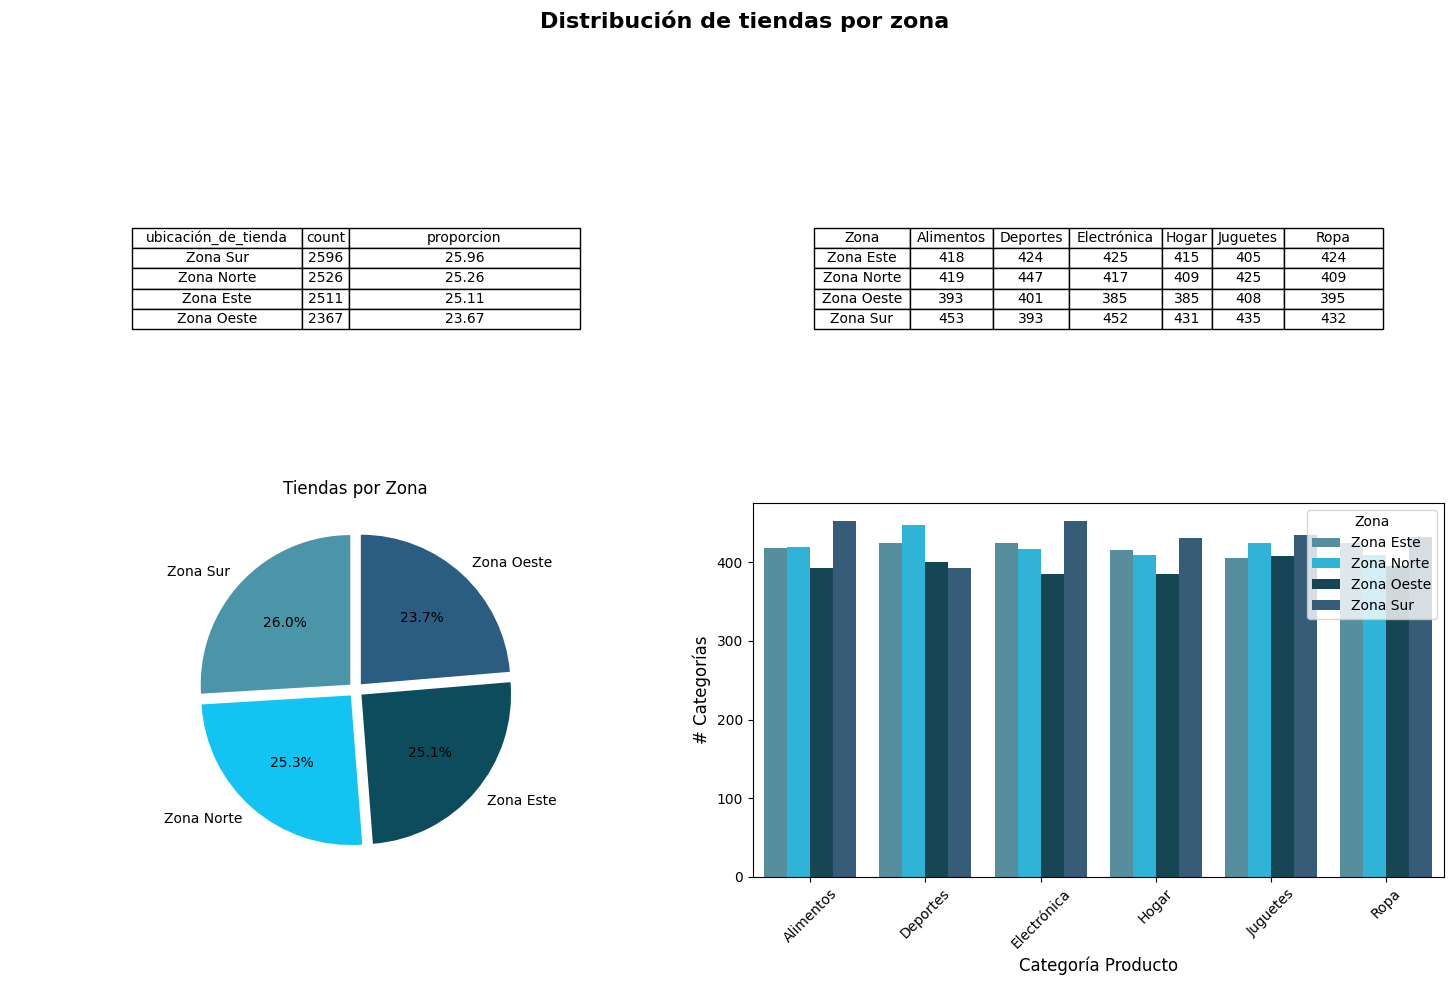

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definimos una paleta de colores
colores = ["#4B95A9", "#13C3F2", "#0C4C5D", "#2B5D83", "#7EA3CC"]  

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Distribución de tiendas por zona", fontsize=16, fontweight='bold')

# Gráfica de pastel
ax_3 = ax[1, 0]
ax_3.pie(
    ubicacion_tiendas["count"],
    labels=ubicacion_tiendas.index,
    autopct="%1.1f%%",
    colors=colores,
    explode=[0.05] * len(ubicacion_tiendas),
    startangle=90
)
ax_3.set_title("Tiendas por Zona", fontsize=12)

# Tabla de la gráfica de pastel
ax_1 = ax[0, 0]
ax_1.axis("tight")
ax_1.axis("off")
tabla = ax_1.table(
    cellText=ubicacion_tiendas.reset_index().values,
    colLabels=ubicacion_tiendas.reset_index().columns,
    loc="center",
    cellLoc="center"
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.auto_set_column_width(col=list(range(len(ubicacion_tiendas.columns))))

# Gráfica de barras
ax_4 = ax[1, 1]
sns.barplot(
    data=tiendas_porcategoria_producto_,
    x="Categoria Producto",
    y="num_total",
    hue="Zona",
    ax=ax_4,
    palette=["#4B95A9", "#13C3F2", "#0C4C5D", "#2B5D83"]
)
ax_4.set_xlabel("Categoría Producto", fontsize=12)
ax_4.set_ylabel("# Categorías", fontsize=12)
ax_4.tick_params(axis='x', rotation=45)
ax_4.legend(title="Zona", fontsize=10)

# Tabla de zonas por categoría de productos
ax_2 = ax[0, 1]
ax_2.axis("tight")
ax_2.axis("off")
tabla_2 = ax_2.table(
    cellText=tiendas_porcategoria_producto.reset_index().values,
    colLabels=tiendas_porcategoria_producto.reset_index().columns,
    loc="center",
    cellLoc="center"
)
tabla_2.auto_set_font_size(False)
tabla_2.set_fontsize(10)
tabla_2.auto_set_column_width(col=list(range(len(tiendas_porcategoria_producto.columns))))

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


In [12]:
'''REalizamos un data frame de las ventas por tienda en unidades y dinero'''

# ventas por tienda en pesos
ventas_tienda = df_ventas.loc[:,["id_tienda","ubicación_de_tienda","total_facturado"]]
ventas_tienda = ventas_tienda.groupby(["id_tienda","ubicación_de_tienda"]).sum().unstack(fill_value=0)
ventas_tienda.index.name = None
ventas_tienda.columns = ventas_tienda.columns.droplevel(0)



# ventas por tienda en unidad
ventas_tienda_unidades = df_ventas.loc[:,["id_tienda","ubicación_de_tienda","cantidad_vendida"]]
ventas_tienda_unidades = ventas_tienda_unidades.groupby(["id_tienda","ubicación_de_tienda"]).sum().unstack(fill_value=0)
ventas_tienda_unidades.index.name = None
ventas_tienda_unidades.columns = ventas_tienda_unidades.columns.droplevel(0)



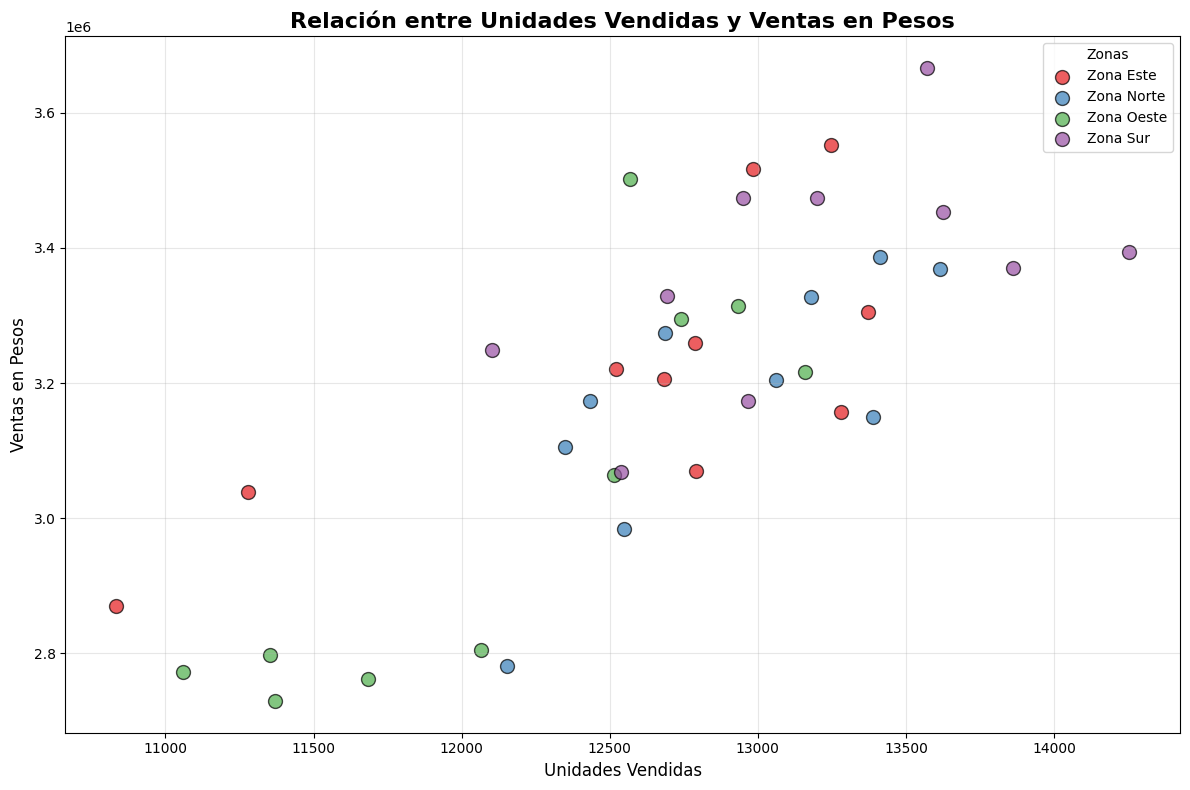

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
colores = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3'] 

for i, zona in enumerate(ventas_tienda.columns):
    ax.scatter(
        ventas_tienda_unidades[zona], ventas_tienda[zona], 
        label=zona, color=colores[i], s=100, alpha=0.7, edgecolor='k'
    )


# Configuración de la gráfica
ax.set_title("Relación entre Unidades Vendidas y Ventas en Pesos", fontsize=16, fontweight='bold')
ax.set_xlabel("Unidades Vendidas", fontsize=12)
ax.set_ylabel("Ventas en Pesos", fontsize=12)
ax.grid(alpha=0.3)
ax.legend(title="Zonas", fontsize=10)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

'''
Aqui podemos observar que de igual manera que en las ventas totales en primer lugar tenemos a la tienda 4
mientras que en ultimo lugar tenemos a la tienda numero 5.

Sin embargo, podemos observar que la tienda numero 8 ocupa el cuarto lugar de piezas vendidas, mientras que en las ventas ocupa el 
tercer lugar, esto indica que vende menos unidades pero tiene mas ingreso de efectivo.

Este comportamiento pasa de la misma manera aa las tiendas 1,2,10 y 6
'''



"""
Ahora se procedera a realizar un grafico para validar la correlacion entre las ventas y las unidades vendidas
"""

Se observa una tendencia positiva entre ambas variables de precio y unidad, lo que nos dice que a medida que aumentas las unidades tambien aumenta la venta ($)

Ahora se validara la distribucion del precio de venta

In [14]:
ventas_tienda["Total"] = ventas_tienda.sum(axis=1)
ventas_tienda["rep_%"] = round(ventas_tienda["Total"] / sum(ventas_tienda["Total"]),5)*100
ventas_tienda.sort_values(by="Total", ascending=False)

ubicación_de_tienda,Zona Este,Zona Norte,Zona Oeste,Zona Sur,Total,rep_%
Tienda_4,3259047.92,3369629.64,3294173.51,3393911.15,13316762.22,10.414
Tienda_3,3156860.15,3274903.31,3502327.20,3371107.21,13305197.87,10.405
Tienda_8,3551947.85,3204433.57,2805605.73,3667012.00,13228999.15,10.346
Tienda_7,3069774.93,3328154.44,3063632.26,3452513.46,12914075.09,10.100
Tienda_1,2870521.41,3149858.79,3314811.71,3473969.44,12809161.35,10.018
Tienda_2,3039391.60,3386872.52,3216542.16,3069256.24,12712062.52,9.942
Tienda_9,3516865.20,3105987.36,2761883.78,3174274.33,12559010.67,9.822
Tienda_6,3206618.74,3173057.54,2797076.92,3328974.57,12505727.77,9.780
Tienda_10,3305542.68,2984489.54,2729646.65,3249078.20,12268757.07,9.595
Tienda_5,3220265.06,2781253.29,2772680.74,3473606.24,12247805.33,9.579


In [15]:
"""
Aqui podemos observar que la tienda con mas ventas es la numero 4 mientras que la tienda numero 5 es la que menos ventas a 
nivel monetario representando el 9.57% del total de las ventas
"""

'\nAqui podemos observar que la tienda con mas ventas es la numero 4 mientras que la tienda numero 5 es la que menos ventas a \nnivel monetario representando el 9.57% del total de las ventas\n'

In [16]:
ventas_tienda_unidades["Total"] = ventas_tienda_unidades.sum(axis=1)
ventas_tienda_unidades["rep_%"] = round(ventas_tienda_unidades["Total"] / sum(ventas_tienda_unidades["Total"]),5)*100
ventas_tienda_unidades.sort_values(by="Total", ascending=False)

ubicación_de_tienda,Zona Este,Zona Norte,Zona Oeste,Zona Sur,Total,rep_%
Tienda_4,12788,13615,12741,14254,53398,10.515
Tienda_3,13279,12688,12570,13860,52397,10.318
Tienda_7,12792,13178,12514,13626,52110,10.262
Tienda_8,13248,13060,12067,13572,51947,10.230
Tienda_2,11280,13412,13158,12537,50387,9.922
Tienda_1,10833,13388,12933,13200,50354,9.916
Tienda_9,12983,12348,11683,12967,49981,9.842
Tienda_10,13371,12548,11370,12103,49392,9.726
Tienda_6,12683,12433,11352,12693,49161,9.681
Tienda_5,12520,12153,11061,12950,48684,9.587


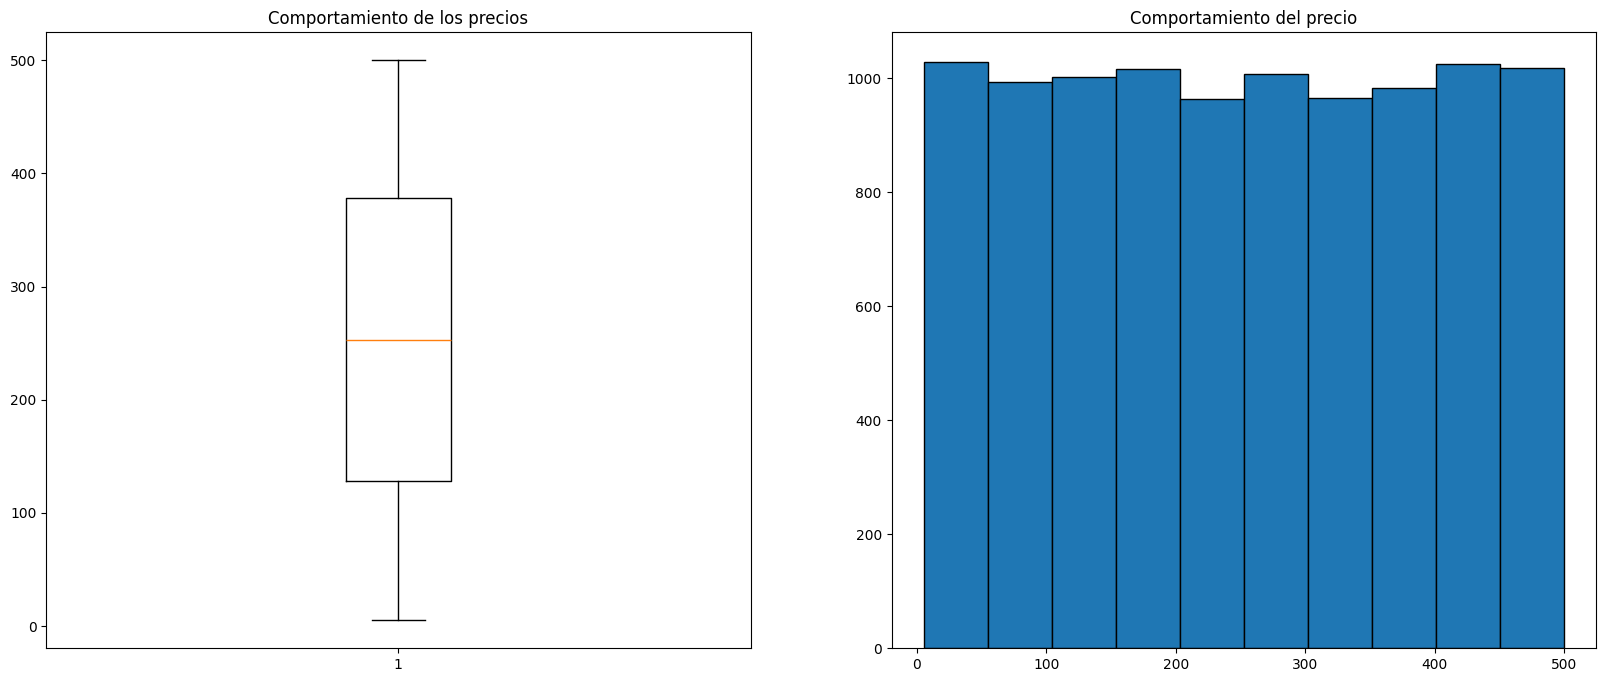

In [17]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize = (20,8))

ax_boxplot = ax[0]
ax_histograma = ax[1]

ax_boxplot.boxplot(x= df_ventas["precio_unitario"])
ax_boxplot.set_title("Comportamiento de los precios")

ax_histograma.hist(x=df_ventas["precio_unitario"], bins=10, edgecolor='black')
ax_histograma.set_title("Comportamiento del precio")


plt.show()

In [18]:
'''
Se puede observar que el comportamiento del precio en general no muestra valores atipicos, ni un sesgo en la variable del precio
lo que indica un precio igualitario en general.

Par comprobar esto, se realizar un analisis del precio por cada categoria y validar si esta sigue una distribucion parecida 
a la general
'''

'\nSe puede observar que el comportamiento del precio en general no muestra valores atipicos, ni un sesgo en la variable del precio\nlo que indica un precio igualitario en general.\n\nPar comprobar esto, se realizar un analisis del precio por cada categoria y validar si esta sigue una distribucion parecida \na la general\n'

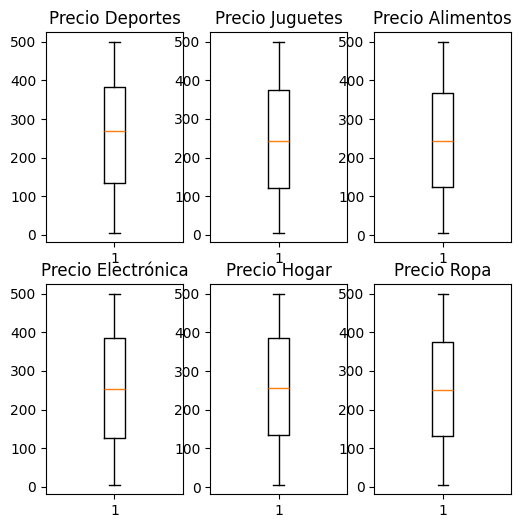

In [19]:
productos = df_ventas["categoría_de_producto"].unique()

fig,ax = plt.subplots(2,3, figsize = (6,6))

for fila,col in enumerate(productos):
    fila_ = fila % 3
    col_ = fila // 3
    ax[col_,fila_].boxplot(df_ventas.loc[df_ventas["categoría_de_producto"]== col,"precio_unitario"])
    ax[col_,fila_].set_title(f"Precio {col}")

In [20]:
'''
Se puede observar que las variables no muestran valores atipicos, ni un sesgo positivo o negativo dejando a la media distribuida en el 
centro, lo que podria indicar una distribución con poca varaibilidad extrema
'''

'\nSe puede observar que las variables no muestran valores atipicos, ni un sesgo positivo o negativo dejando a la media distribuida en el \ncentro, lo que podria indicar una distribución con poca varaibilidad extrema\n'

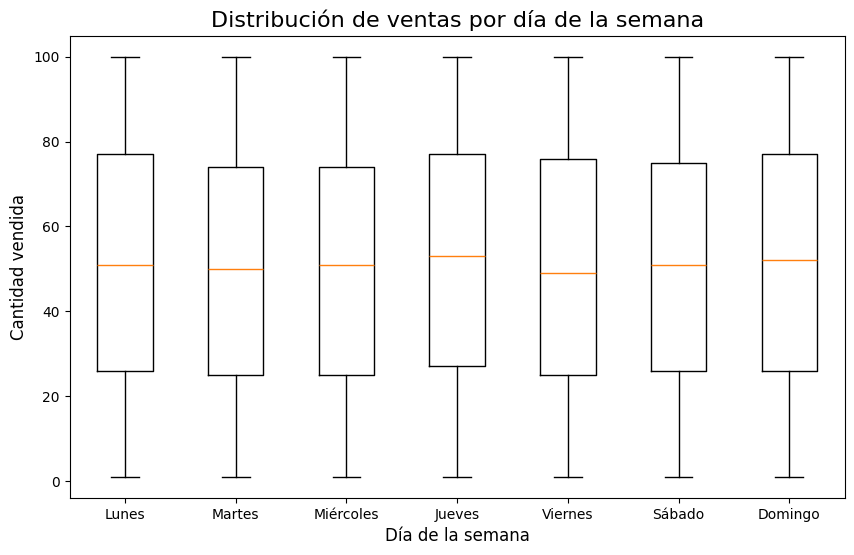

In [21]:
"""Validamos la distribucion de las ventas por dia de la semana"""

# Se extrae el día de la semana 
df_ventas['dia_de_la_semana'] = df_ventas['fecha_de_venta'].dt.dayofweek

# Crear el boxplot de ventas por día de la semana
plt.figure(figsize=(10, 6))
plt.boxplot([df_ventas[df_ventas['dia_de_la_semana'] == day]['cantidad_vendida'] for day in range(7)], 
            tick_labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])

# Añadir títulos y etiquetas
plt.title('Distribución de ventas por día de la semana', fontsize=16)
plt.xlabel('Día de la semana', fontsize=12)
plt.ylabel('Cantidad vendida', fontsize=12)

plt.show()

In [22]:
# validamos los datos de cada dia ("sus ventas por dia, en promedio y mediana")
for i in df_ventas["dia_de_la_semana"].unique():
    print(i)
    print(df_ventas.loc[df_ventas["dia_de_la_semana"]== i, "cantidad_vendida"].describe())
    print("*"*50)

0
count    1413.000000
mean       50.790517
std        29.158281
min         1.000000
25%        26.000000
50%        51.000000
75%        77.000000
max       100.000000
Name: cantidad_vendida, dtype: float64
**************************************************
2
count    1455.000000
mean       50.422680
std        28.718827
min         1.000000
25%        25.000000
50%        51.000000
75%        74.000000
max       100.000000
Name: cantidad_vendida, dtype: float64
**************************************************
6
count    1428.000000
mean       51.270308
std        29.462573
min         1.000000
25%        26.000000
50%        52.000000
75%        77.000000
max       100.000000
Name: cantidad_vendida, dtype: float64
**************************************************
3
count    1433.000000
mean       51.942777
std        28.616777
min         1.000000
25%        27.000000
50%        53.000000
75%        77.000000
max       100.000000
Name: cantidad_vendida, dtype: float64
***********

Podemos observar que los dias:
* Jueves se tiene la mediana más alta (53), seguido de Domingo (52) y Miércoles (53).
* Martes y Viernes son los días con las medianas más bajas, con 50 y 49, respectivamente.
* Los días de la semana con promedios más altos son Miércoles y Domingo, mientras que Martes tiene el promedio más bajo.

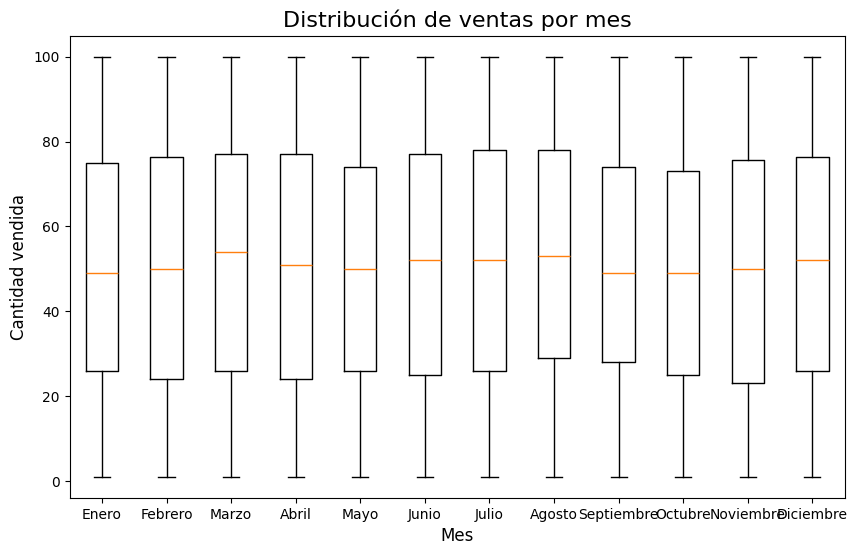

In [23]:
df_ventas['mes'] = df_ventas['fecha_de_venta'].dt.month

# Crear el boxplot de ventas por mes
plt.figure(figsize=(10, 6))
plt.boxplot([df_ventas[df_ventas['mes'] == month]['cantidad_vendida'] for month in range(1, 13)], 
            tick_labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto','Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])

# le asignamos nombres de sus ejes y titulo
plt.title('Distribución de ventas por mes', fontsize=16)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Cantidad vendida', fontsize=12)

plt.show()

In [24]:
# validamos los datos de cada mes ("sus ventas por mes, en promedio y mediana")
for i in df_ventas["mes"].unique():
    print(i)
    print(df_ventas.loc[df_ventas["mes"]== i, "cantidad_vendida"].describe())
    print("*"*50)

2
count    732.000000
mean      50.431694
std       29.113852
min        1.000000
25%       24.000000
50%       50.000000
75%       76.250000
max      100.000000
Name: cantidad_vendida, dtype: float64
**************************************************
4
count    799.000000
mean      50.827284
std       29.443293
min        1.000000
25%       24.000000
50%       51.000000
75%       77.000000
max      100.000000
Name: cantidad_vendida, dtype: float64
**************************************************
5
count    861.000000
mean      49.953542
std       28.738479
min        1.000000
25%       26.000000
50%       50.000000
75%       74.000000
max      100.000000
Name: cantidad_vendida, dtype: float64
**************************************************
8
count    843.000000
mean      52.659549
std       28.904407
min        1.000000
25%       29.000000
50%       53.000000
75%       78.000000
max      100.000000
Name: cantidad_vendida, dtype: float64
*******************************************

Como podemos observar las ventas en unidades por mes son:
* Agosto tiene el promedio más alto con 52.66, seguido de Julio (51.82) y Marzo (51.68).
* Enero y Octubre tienen los promedios más bajos, con 49.93 y 49.40 respectivamente.
* En general, los meses con mayores promedios de ventas son Agosto, Julip y Marzo.
* Los meses con menores promedios de ventas son Enero, Octubre y Mayo.

<a id="cpcv"></a>
## Clasificación de productos por comportamiento de venta

Para realizar una clasificacion de productos por comportamiento de venta, se realizara:
* creación de nuevas variables
* Agrupar los productos y calcular métricas clave
* Realizar una primera clasificacion basada en ingresos totales

* Agregamos y eliminamos algunas variables

In [25]:
df_clasificacion_productos = df_ventas.copy()

# eliminamos las variables mes y dia, ya que tenemos por ahora la varibales fecha
df_clasificacion_productos.drop(columns= ["dia_de_la_semana","mes"],inplace=True)


# se añaden la variable rotacion teniendo en cuenta que ya tenemos la variables ventas totales creada anteriormente

df_clasificacion_productos["rotacion_inventario"] = df_clasificacion_productos["cantidad_vendida"] / df_clasificacion_productos["nivel_de_inventario"]

In [26]:
df_clasificacion_productos[["id_producto","rotacion_inventario"]][:5]

,id_producto,rotacion_inventario
0,Producto_43,8.10
1,Producto_22,0.25
2,Producto_27,0.13
3,Producto_6,1.34
4,Producto_1,0.07


In [27]:
"""
se puede observar con los primeros 5 datos que la rotacion de producto 43 tiene un alta rotación, lo que nos dice que se mueve rapidamente
> el item 22 se mueve poco, por lo tanto este roducto se mueve muy lentamente
> El item 6 nos indica que no se mueve tampoco muy rapido, su movimiento es lento
"""

'\nse puede observar con los primeros 5 datos que la rotacion de producto 43 tiene un alta rotación, lo que nos dice que se mueve rapidamente\n> el item 22 se mueve poco, por lo tanto este roducto se mueve muy lentamente\n> El item 6 nos indica que no se mueve tampoco muy rapido, su movimiento es lento\n'

In [28]:
df_clasificacion_productos[:2]

,id_producto,id_tienda,fecha_de_venta,cantidad_vendida,precio_unitario,categoría_de_producto,ubicación_de_tienda,promoción_o_descuento,estacionalidad,método_de_pago,nivel_de_inventario,total_facturado,rotacion_inventario
0,Producto_43,Tienda_2,2023-02-13,81,498.48,Deportes,Zona Este,1,1,Efectivo,10,40376.88,8.10
1,Producto_22,Tienda_1,2023-04-19,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100,5111.50,0.25


In [29]:
# Una ves creadas las variables, podemos realizar una agrupacion de los distintos productos

clasificación_productos = df_clasificacion_productos.groupby("id_producto").agg({"cantidad_vendida":"sum",'rotacion_inventario': 'mean','precio_unitario': 'mean','total_facturado': 'sum'}).sort_values(by="total_facturado", ascending=False)
clasificación_productos

,cantidad_vendida,rotacion_inventario,precio_unitario,total_facturado
id_producto,,,,
Producto_23,11543,2.416120,263.616804,3085552.66
Producto_48,11460,2.157212,269.861374,2955232.83
Producto_32,11244,2.694073,259.502785,2946221.94
Producto_14,10462,2.375759,266.403596,2894707.95
Producto_21,10925,2.595205,255.918927,2818599.25
Producto_37,10563,2.310680,260.486550,2799587.02
Producto_20,11186,2.039847,239.606211,2778485.74
Producto_6,10997,2.182056,252.921884,2777344.85
Producto_36,10652,2.706565,259.686893,2741243.77


**Aqui podemos observar que cuales son los productos que en promedio tienen mayor venta en pesos**
* En primer lugar tenemos al articulo numero 23
* En ultimo lugar tenemos articulo 28


Con base a estos resultados podemos realizar una clasificacion basada en ngresos, aunque tambien se podria por unidades vendidas
y observar si existe alguna diferencia

In [30]:
# ahora podemos realizar una clasificacion basada en ingresos $, con la tecnica de los cuartiles
clasificación_productos["categoria"] = pd.qcut(clasificación_productos["total_facturado"],q=3,labels=["Bajo","Medio","Alto"])
clasificacion_productos_venta_pesos = clasificación_productos.copy()
clasificacion_productos_venta_pesos.reset_index(inplace=True)
clasificacion_productos_venta_pesos

,id_producto,cantidad_vendida,rotacion_inventario,precio_unitario,total_facturado,categoria
0,Producto_23,11543,2.416120,263.616804,3085552.66,Alto
1,Producto_48,11460,2.157212,269.861374,2955232.83,Alto
2,Producto_32,11244,2.694073,259.502785,2946221.94,Alto
3,Producto_14,10462,2.375759,266.403596,2894707.95,Alto
4,Producto_21,10925,2.595205,255.918927,2818599.25,Alto
5,Producto_37,10563,2.310680,260.486550,2799587.02,Alto
6,Producto_20,11186,2.039847,239.606211,2778485.74,Alto
7,Producto_6,10997,2.182056,252.921884,2777344.85,Alto
8,Producto_36,10652,2.706565,259.686893,2741243.77,Alto
9,Producto_16,10559,2.371513,257.690194,2736781.07,Alto


In [31]:
clasificacion_productos_venta_unidades = clasificacion_productos_venta_pesos.copy()
clasificacion_productos_venta_unidades["categoria"] = pd.qcut(clasificacion_productos_venta_unidades["cantidad_vendida"],q=3,labels=["Bajo","Medio","Alto"])
clasificacion_productos_venta_unidades.reset_index(inplace=True, drop=True)
clasificacion_productos_venta_unidades.reset_index(drop = True).sort_values(by="cantidad_vendida",ascending=False)

,id_producto,cantidad_vendida,rotacion_inventario,precio_unitario,total_facturado,categoria
0,Producto_23,11543,2.416120,263.616804,3085552.66,Alto
1,Producto_48,11460,2.157212,269.861374,2955232.83,Alto
2,Producto_32,11244,2.694073,259.502785,2946221.94,Alto
6,Producto_20,11186,2.039847,239.606211,2778485.74,Alto
14,Producto_41,11009,2.308850,243.075072,2688225.23,Alto
7,Producto_6,10997,2.182056,252.921884,2777344.85,Alto
13,Producto_50,10985,2.384498,254.345484,2713628.87,Alto
4,Producto_21,10925,2.595205,255.918927,2818599.25,Alto
31,Producto_22,10909,2.445471,241.652095,2516989.43,Alto
10,Producto_4,10806,2.687008,251.482650,2716338.19,Alto


In [32]:
# resumimos nuestros resultados en dinero
productos_comportamientos_venta = clasificacion_productos_venta_pesos[["categoria","total_facturado"]].groupby("categoria",observed=False).mean()
productos_comportamientos_venta["total_facturado"] = productos_comportamientos_venta["total_facturado"].apply(lambda x: f"${x:,.2f}")


# resumimos nuestros resultados de comportamiento en unidades
productos_comportamientos_unidades = clasificacion_productos_venta_pesos[["categoria","cantidad_vendida"]].groupby("categoria",observed=False).mean()
productos_comportamientos_unidades["cantidad_vendida"] = productos_comportamientos_unidades["cantidad_vendida"].apply(lambda x: f"{x:,.2f}")

# df resumen
df_productos = pd.concat([productos_comportamientos_venta,productos_comportamientos_unidades], axis=1)
df_productos


,total_facturado,cantidad_vendida
categoria,,
Bajo,"$2,316,003.55","9,542.24"
Medio,"$2,566,628.91","10,201.56"
Alto,"$2,789,966.83","10,727.53"


In [33]:
'''
Los productos son considerados de la siguiente manera:

> Productos con alto desempeño: Son productos con ventas promedio de $2,789,966.83 y una venta en unidades promedio de: 10,727.53
> Productos con desempeño medio: Son productos con ventas promedio de $2,566,628.91 y una venta en unidades promedio de: 10,201.56
> Productos con desempeño bajo: Son productos con ventas promedio de $2,316,003.55 y una venta en unidades promedio de: 9,542.24

'''

'\nLos productos son considerados de la siguiente manera:\n\n> Productos con alto desempeño: Son productos con ventas promedio de $2,789,966.83 y una venta en unidades promedio de: 10,727.53\n> Productos con desempeño medio: Son productos con ventas promedio de $2,566,628.91 y una venta en unidades promedio de: 10,201.56\n> Productos con desempeño bajo: Son productos con ventas promedio de $2,316,003.55 y una venta en unidades promedio de: 9,542.24\n\n'

<a id="ctcv"></a>
## Clasificación de tiendas por comportamientos de venta

In [34]:
df = df_ventas.copy()
df["rotacion_inventario"] = df["cantidad_vendida"] / df["nivel_de_inventario"]
df[:4]

,id_producto,id_tienda,fecha_de_venta,cantidad_vendida,precio_unitario,categoría_de_producto,ubicación_de_tienda,promoción_o_descuento,estacionalidad,método_de_pago,nivel_de_inventario,total_facturado,dia_de_la_semana,mes,rotacion_inventario
0,Producto_43,Tienda_2,2023-02-13,81,498.48,Deportes,Zona Este,1,1,Efectivo,10,40376.88,0,2,8.10
1,Producto_22,Tienda_1,2023-04-19,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100,5111.50,2,4,0.25
2,Producto_27,Tienda_6,2022-05-29,13,253.30,Alimentos,Zona Este,1,0,Crédito,100,3292.90,6,5,0.13
3,Producto_6,Tienda_6,2022-08-15,67,134.23,Electrónica,Zona Norte,0,1,Efectivo,50,8993.41,0,8,1.34


In [35]:
# ajustamos la cantidad de columnas a poder observar:
pd.options.display.max_columns = 50

# generamos un resumen para entender como es que se comportan las ventas por tiendas
df_summary = df_ventas.groupby('id_tienda').agg({
    'total_facturado': 'mean',
    'cantidad_vendida': 'mean',
    'nivel_de_inventario': 'mean',
    'precio_unitario': 'mean',
    'ubicación_de_tienda': 'first'
}).reset_index()

df_summary

,id_tienda,total_facturado,cantidad_vendida,nivel_de_inventario,precio_unitario,ubicación_de_tienda
0,Tienda_1,13030.682960,51.224822,144.745677,255.215198,Zona Norte
1,Tienda_10,12330.409116,49.640201,128.567839,252.297809,Zona Sur
2,Tienda_2,12775.942231,50.640201,132.201005,254.258492,Zona Este
3,Tienda_3,13186.519197,51.929633,133.706640,257.601249,Zona Oeste
4,Tienda_4,12780.002131,51.245681,126.046065,249.248964,Zona Este
5,Tienda_5,12321.735744,48.977867,134.320926,253.768592,Zona Este
6,Tienda_6,12813.245666,50.369877,142.884221,252.560768,Zona Este
7,Tienda_7,12914.075090,52.110000,137.185000,243.504510,Zona Sur
8,Tienda_8,13059.229171,51.280355,133.440276,254.191807,Zona Norte
9,Tienda_9,12647.543474,50.333333,128.373615,251.749396,Zona Oeste


In [36]:
df_ventas_tiendas = pd.concat([ventas_tienda,ventas_tienda_unidades],axis = 1)
df_ventas_tiendas

ubicación_de_tienda,Zona Este,Zona Norte,Zona Oeste,Zona Sur,Total,rep_%,Zona Este,Zona Norte,Zona Oeste,Zona Sur,Total,rep_%
Tienda_1,2870521.41,3149858.79,3314811.71,3473969.44,12809161.35,10.018,10833,13388,12933,13200,50354,9.916
Tienda_10,3305542.68,2984489.54,2729646.65,3249078.20,12268757.07,9.595,13371,12548,11370,12103,49392,9.726
Tienda_2,3039391.60,3386872.52,3216542.16,3069256.24,12712062.52,9.942,11280,13412,13158,12537,50387,9.922
Tienda_3,3156860.15,3274903.31,3502327.20,3371107.21,13305197.87,10.405,13279,12688,12570,13860,52397,10.318
Tienda_4,3259047.92,3369629.64,3294173.51,3393911.15,13316762.22,10.414,12788,13615,12741,14254,53398,10.515
Tienda_5,3220265.06,2781253.29,2772680.74,3473606.24,12247805.33,9.579,12520,12153,11061,12950,48684,9.587
Tienda_6,3206618.74,3173057.54,2797076.92,3328974.57,12505727.77,9.780,12683,12433,11352,12693,49161,9.681
Tienda_7,3069774.93,3328154.44,3063632.26,3452513.46,12914075.09,10.100,12792,13178,12514,13626,52110,10.262
Tienda_8,3551947.85,3204433.57,2805605.73,3667012.00,13228999.15,10.346,13248,13060,12067,13572,51947,10.230
Tienda_9,3516865.20,3105987.36,2761883.78,3174274.33,12559010.67,9.822,12983,12348,11683,12967,49981,9.842


<a id = "cp"></a>
## Clustering de productos

Se preparan los datos para crear el modelo

In [80]:
# Realiza un análisis de clustering para agrupar las tiendas según sus comportamientos de venta (por ejemplo, por volumen de ventas, frecuencia de ventas, etc.).
df_productos = df.copy()

# creamos la variable año
df_productos["year"]=df_productos["fecha_de_venta"].dt.year

# eliminamos algunas variables que no se ocuparan en el analisis
df_productos = df_productos.drop(columns=["id_tienda","dia_de_la_semana","fecha_de_venta"])

df_productos[:4]

,id_producto,cantidad_vendida,precio_unitario,categoría_de_producto,ubicación_de_tienda,promoción_o_descuento,estacionalidad,método_de_pago,nivel_de_inventario,total_facturado,mes,rotacion_inventario,year
0,Producto_43,81,498.48,Deportes,Zona Este,1,1,Efectivo,10,40376.88,2,8.10,2023
1,Producto_22,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100,5111.50,4,0.25,2023
2,Producto_27,13,253.30,Alimentos,Zona Este,1,0,Crédito,100,3292.90,5,0.13,2022
3,Producto_6,67,134.23,Electrónica,Zona Norte,0,1,Efectivo,50,8993.41,8,1.34,2022


In [83]:
# instanciamos
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Declaramos las variables categóricas a transformar
categorical_columns = ["id_producto","categoría_de_producto","ubicación_de_tienda","método_de_pago"]

# Inicializamos el DataFrame para las columnas codificadas
df_hot_encoded = pd.DataFrame(index=df.index)

# Iteramos sobre cada columna categórica
for i in categorical_columns:
    # Manejamos posibles valores nulos
    df_productos[i].fillna('Unknown', inplace=True)

    # Transformamos la columna (convertimos la matriz dispersa en densa con `sparse=False`)
    columna_convertida_one_hot = onehot_encoder.fit_transform(df_productos[[i]])

    # Nombres de las nuevas columnas
    columnas = [f"{i}_{h}" for h in onehot_encoder.categories_[0]]

    # Creación de un DataFrame temporal con las columnas transformadas
    df_var_encoder = pd.DataFrame(columna_convertida_one_hot, columns=columnas, index=df_productos.index)

    # Concatenamos las nuevas columnas con el DataFrame codificado
    df_hot_encoded = pd.concat([df_hot_encoded, df_var_encoder], axis=1)

# Concat el DataFrame original con las nuevas columnas codificadas y eliminar las originales
df_productos = pd.concat([df_productos.drop(columns=categorical_columns), df_hot_encoded], axis=1)




# OrdinalEncoder a las variables:
ordinal_encoder = OrdinalEncoder()
columnas_encoder = ["mes", "year"]

# Transformamos las columnas 
for columna in columnas_encoder:
    if columna in df_productos.columns:
        df_productos[columna] = ordinal_encoder.fit_transform(df_productos[[columna]])

In [85]:
df_productos[["cantidad_vendida","precio_unitario","nivel_de_inventario","total_facturado","rotacion_inventario"]] = (df_productos[["cantidad_vendida","precio_unitario","nivel_de_inventario","total_facturado","rotacion_inventario"]]
                                                                                                                      .apply(lambda x: np.log(x+1)))

df_productos

,cantidad_vendida,precio_unitario,promoción_o_descuento,estacionalidad,nivel_de_inventario,total_facturado,mes,rotacion_inventario,year,id_producto_Producto_1,id_producto_Producto_10,id_producto_Producto_11,id_producto_Producto_12,id_producto_Producto_13,id_producto_Producto_14,id_producto_Producto_15,id_producto_Producto_16,id_producto_Producto_17,id_producto_Producto_18,id_producto_Producto_19,id_producto_Producto_2,id_producto_Producto_20,id_producto_Producto_21,id_producto_Producto_22,id_producto_Producto_23,...,id_producto_Producto_44,id_producto_Producto_45,id_producto_Producto_46,id_producto_Producto_47,id_producto_Producto_48,id_producto_Producto_49,id_producto_Producto_5,id_producto_Producto_50,id_producto_Producto_6,id_producto_Producto_7,id_producto_Producto_8,id_producto_Producto_9,categoría_de_producto_Alimentos,categoría_de_producto_Deportes,categoría_de_producto_Electrónica,categoría_de_producto_Hogar,categoría_de_producto_Juguetes,categoría_de_producto_Ropa,ubicación_de_tienda_Zona Este,ubicación_de_tienda_Zona Norte,ubicación_de_tienda_Zona Oeste,ubicación_de_tienda_Zona Sur,método_de_pago_Crédito,método_de_pago_Efectivo,método_de_pago_Tarjeta
0,4.406719,6.213568,1,1,2.397895,10.606037,1.0,2.208274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.258097,5.325251,0,1,4.615121,8.539444,3.0,0.223144,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.639057,5.538515,1,0,4.615121,8.099828,4.0,0.122218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.219508,4.906977,0,1,3.931826,9.104359,7.0,0.850151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,3.091042,5.801514,1,0,5.707110,8.843153,1.0,0.067659,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.663562,5.938960,1,1,3.433987,9.573977,11.0,0.818310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9996,4.382027,4.370334,1,1,6.216606,8.727216,6.0,0.146694,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9997,2.639057,5.526966,0,1,3.931826,8.088236,0.0,0.231112,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9998,4.248495,5.996676,1,1,3.044522,10.228328,9.0,1.492904,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


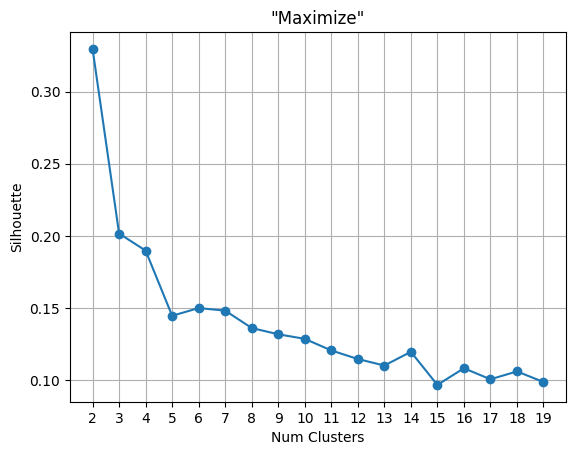

In [87]:
'''Número de agrupaciones utilizando la gráfica K-Elbow y el índice Silhouette'''


x_prod = df_productos.to_numpy()
np.random.seed(0)
# definimos el numero de clusters
nc = 20

# creamos un diccionario para agregar la informacion
results = {}
for k in range(2, nc):
  k_means = cluster.KMeans(n_clusters=k).fit(x_prod)
  y_pred = k_means.predict(x_prod)
  results[k] = metrics.silhouette_score(x_prod, y_pred)

# agregamos las metricas arrojadas a variables para graficas
clusters_counts = list(results.keys())
index_values = list(results.values())


# graficamos el numero de clusters optimo
plt.plot(clusters_counts, index_values, 'o-')
plt.grid(True)
plt.title('"Maximize"')
plt.xlabel('Num Clusters')
plt.xticks(clusters_counts)
plt.ylabel('Silhouette')
plt.show()

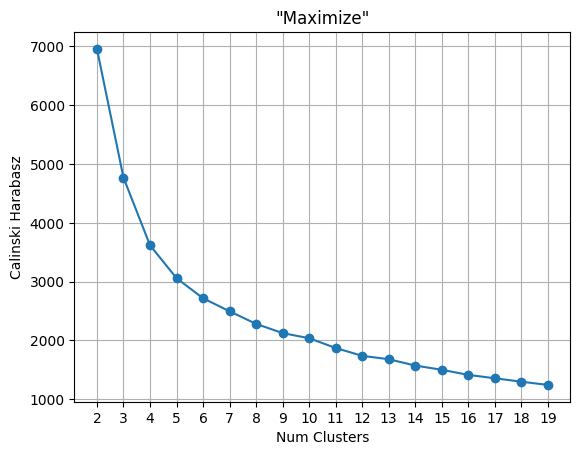

In [88]:
'''Realizamos otra comparacion de nuemro de clusters pero ahora con el indice calinski'''
y_preds = []
results = {}
for k in range(2, nc):
  k_means = cluster.KMeans(n_clusters=k).fit(x_prod)
  y_pred_prod = k_means.predict(x_prod)
  y_preds.append(y_pred_prod)
  results[k] = metrics.calinski_harabasz_score(x_prod, y_pred_prod)

clusters_counts = list(results.keys())
index_values = list(results.values())

# grafica
plt.plot(clusters_counts, index_values, 'o-')
plt.grid(True)
plt.title('"Maximize"')
plt.xlabel('Num Clusters')
plt.xticks(clusters_counts)
plt.ylabel('Calinski Harabasz')
plt.show()

In [89]:
k = 6  # numero de clusters optimo

k_means = cluster.KMeans(n_clusters=k)
y_pred1_prod = k_means.fit_predict(x_prod)
s1 = metrics.silhouette_score(x_prod, y_pred1_prod)

single_linkage = cluster.AgglomerativeClustering(linkage="single", n_clusters=k)
y_pred2_prod = single_linkage.fit_predict(x_prod)
s2 = metrics.silhouette_score(x_prod, y_pred2_prod)

spectral = cluster.SpectralClustering(n_clusters=k, affinity="nearest_neighbors")
y_pred3_prod = spectral.fit_predict(x_prod)
s3 = metrics.silhouette_score(x_prod, y_pred3_prod)

In [91]:
df_productos[:2]

,cantidad_vendida,precio_unitario,promoción_o_descuento,estacionalidad,nivel_de_inventario,total_facturado,mes,rotacion_inventario,year,id_producto_Producto_1,id_producto_Producto_10,id_producto_Producto_11,id_producto_Producto_12,id_producto_Producto_13,id_producto_Producto_14,id_producto_Producto_15,id_producto_Producto_16,id_producto_Producto_17,id_producto_Producto_18,id_producto_Producto_19,id_producto_Producto_2,id_producto_Producto_20,id_producto_Producto_21,id_producto_Producto_22,id_producto_Producto_23,...,id_producto_Producto_44,id_producto_Producto_45,id_producto_Producto_46,id_producto_Producto_47,id_producto_Producto_48,id_producto_Producto_49,id_producto_Producto_5,id_producto_Producto_50,id_producto_Producto_6,id_producto_Producto_7,id_producto_Producto_8,id_producto_Producto_9,categoría_de_producto_Alimentos,categoría_de_producto_Deportes,categoría_de_producto_Electrónica,categoría_de_producto_Hogar,categoría_de_producto_Juguetes,categoría_de_producto_Ropa,ubicación_de_tienda_Zona Este,ubicación_de_tienda_Zona Norte,ubicación_de_tienda_Zona Oeste,ubicación_de_tienda_Zona Sur,método_de_pago_Crédito,método_de_pago_Efectivo,método_de_pago_Tarjeta
0,4.406719,6.213568,1,1,2.397895,10.606037,1.0,2.208274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.258097,5.325251,0,1,4.615121,8.539444,3.0,0.223144,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


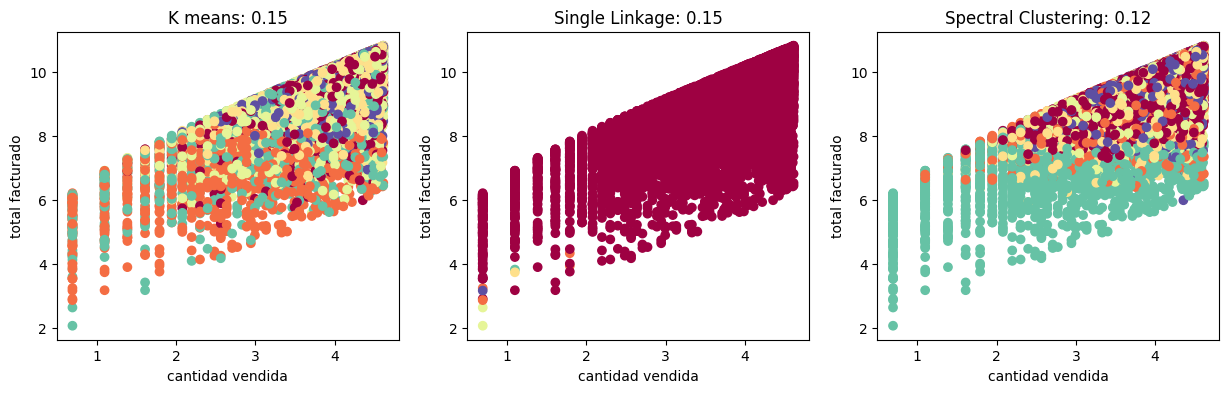

In [93]:
'''Se grafican los distintos algoritmos'''

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15,4))
ax0.scatter(x_prod[:, 0], x_prod[:, 5], c=y_pred1_prod, cmap=plt.cm.Spectral)
ax0.set_title('K means: '+"{:.2f}".format(s1))
ax0.set_xlabel("cantidad vendida")
ax0.set_ylabel('total facturado')

ax1.scatter(x_prod[:, 0], x_prod[:, 5], c=y_pred2_prod, cmap=plt.cm.Spectral)
ax1.set_title('Single Linkage: '+"{:.2f}".format(s2))
ax1.set_xlabel("cantidad vendida")
ax1.set_ylabel('total facturado')

ax2.scatter(x_prod[:, 0], x_prod[:, 5], c=y_pred3_prod, cmap=plt.cm.Spectral)
ax2.set_title('Spectral Clustering: '+"{:.2f}".format(s3))
ax2.set_xlabel("cantidad vendida")
ax2.set_ylabel('total facturado')
plt.show()

In [102]:
'''Segamentacion de los datos'''
df_productos = df_ventas.copy()
df_productos.drop(columns=["fecha_de_venta","promoción_o_descuento",	"estacionalidad","dia_de_la_semana","mes"], inplace=True)

df_productos["grupos"] = y_pred1_prod
df_productos_ = [df_productos[df_productos['grupos']==g] for g in range(k)]

# validamos cuantos grupos tenemos:
for g in range(k):
    print('Grupo'+str(g),'has',len(df_productos_[g]),'tiendas')

Grupo0 has 1716 tiendas
Grupo1 has 1000 tiendas
Grupo2 has 1800 tiendas
Grupo3 has 2316 tiendas
Grupo4 has 1718 tiendas
Grupo5 has 1450 tiendas


In [103]:
df_productos[:2]

,id_producto,id_tienda,cantidad_vendida,precio_unitario,categoría_de_producto,ubicación_de_tienda,método_de_pago,nivel_de_inventario,total_facturado,grupos
0,Producto_43,Tienda_2,81,498.48,Deportes,Zona Este,Efectivo,10,40376.88,3
1,Producto_22,Tienda_1,25,204.46,Juguetes,Zona Norte,Crédito,100,5111.50,3


In [107]:
'''Realizamos un dataframe para resumir nuestros datos'''

grupos_productos = pd.DataFrame() #dataframe vacío
# Añadimos columna para poner el nombre de las variables en cada fila
grupos_productos['Features'] = df_productos.columns[:-1]
# promedio de cada variable dentro de cada grupo
for g in range(k):
    row = []
    for col in grupos_productos['Features']:
        if df_productos_[g][col].dtype != 'object':
            row.append(np.round(df_productos_[g][col].mean(),2))
        else:
            row.append(df_productos_[g][col].value_counts().keys()[0])
    grupos_productos['Grupo'+str(g)] = row

grupos_productos

,Features,Grupo0,Grupo1,Grupo2,Grupo3,Grupo4,Grupo5
0,id_producto,Producto_50,Producto_35,Producto_20,Producto_50,Producto_49,Producto_32
1,id_tienda,Tienda_4,Tienda_4,Tienda_3,Tienda_10,Tienda_1,Tienda_2
2,cantidad_vendida,58.27,21.33,57.73,52.69,42.11,60.84
3,precio_unitario,269.39,129.87,286.6,269.04,229.65,274.91
4,categoría_de_producto,Alimentos,Juguetes,Electrónica,Ropa,Ropa,Hogar
5,ubicación_de_tienda,Zona Este,Zona Sur,Zona Sur,Zona Sur,Zona Sur,Zona Sur
6,método_de_pago,Tarjeta,Tarjeta,Efectivo,Crédito,Efectivo,Tarjeta
7,nivel_de_inventario,20.08,125.51,228.92,160.92,216.71,16.4
8,total_facturado,15326.8,1248.44,16057.63,13838.22,9338.77,16083.64


In [108]:
grupos_productos = grupos_productos.transpose()
grupos_productos.columns = grupos_productos.loc["Features"]
grupos_productos = grupos_productos.drop("Features")
grupos_productos = grupos_productos[["cantidad_vendida","precio_unitario","nivel_de_inventario","total_facturado"]]
grupos_productos

Features,cantidad_vendida,precio_unitario,nivel_de_inventario,total_facturado
Grupo0,58.27,269.39,20.08,15326.8
Grupo1,21.33,129.87,125.51,1248.44
Grupo2,57.73,286.6,228.92,16057.63
Grupo3,52.69,269.04,160.92,13838.22
Grupo4,42.11,229.65,216.71,9338.77
Grupo5,60.84,274.91,16.4,16083.64


In [110]:
for i in grupos_productos.columns:
    grupos_productos[i] = grupos_productos[i].astype("float64")

grupos_productos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, Grupo0 to Grupo5
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cantidad_vendida     6 non-null      float64
 1   precio_unitario      6 non-null      float64
 2   nivel_de_inventario  6 non-null      float64
 3   total_facturado      6 non-null      float64
dtypes: float64(4)
memory usage: 240.0+ bytes


In [113]:
import plotly.graph_objects as go
Xt_prod = grupos_productos.apply(lambda x: np.log(x+1)).to_numpy()
fig = go.Figure()
for j in range(len(grupos_productos)):
  fig.add_trace(go.Bar(
      y=Xt_prod[j,:],
      x=grupos_productos.columns,
      name='Group '+str(j)
  ))
fig.update_layout(
    title='Promedio por grupo',
    yaxis_title='valores normalizados',
    margin=dict(l=50, r=50, t=50, b=50)
)
fig.show()

<a id ="ct"></a>
## Clustering de tiendas

In [38]:
# Realiza un análisis de clustering para agrupar las tiendas según sus comportamientos de venta (por ejemplo, por volumen de ventas, frecuencia de ventas, etc.).
df_tiendas = df.copy()

# creamos la variable año
df_tiendas["year"]=df_tiendas["fecha_de_venta"].dt.year

# eliminamos algunas variables que no se ocuparan en el analisis
df_tiendas = df_tiendas.drop(columns=["dia_de_la_semana","método_de_pago","fecha_de_venta","id_producto"])

df_tiendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_tienda              10000 non-null  object 
 1   cantidad_vendida       10000 non-null  int64  
 2   precio_unitario        10000 non-null  float64
 3   categoría_de_producto  10000 non-null  object 
 4   ubicación_de_tienda    10000 non-null  object 
 5   promoción_o_descuento  10000 non-null  int64  
 6   estacionalidad         10000 non-null  int64  
 7   nivel_de_inventario    10000 non-null  int64  
 8   total_facturado        10000 non-null  float64
 9   mes                    10000 non-null  int32  
 10  rotacion_inventario    10000 non-null  float64
 11  year                   10000 non-null  int32  
dtypes: float64(3), int32(2), int64(4), object(3)
memory usage: 859.5+ KB


In [39]:
'''Transformacion de variables'''


# OrdinalEncoder a las variables:
columnas_encoder = ["mes", "year", "id_tienda", "categoría_de_producto"]

# Transformamos las columnas 
for columna in columnas_encoder:
    if columna in df_tiendas.columns:
        df_tiendas[columna] = ordinal_encoder.fit_transform(df_tiendas[[columna]])

categorical_columns = ["ubicación_de_tienda"]

# Validamos que las columnas existan antes de transformar
if all(col in df_tiendas.columns for col in categorical_columns):
    ubicacion_tiendas = onehot_encoder.fit_transform(df_tiendas[categorical_columns])
    
    # extraemos las nuevas columnas
    columnas = [f"{categorical_columns[0]}_{h}" for h in onehot_encoder.categories_[0]]

    # Crear DataFrame con las columnas nuevas
    df_var_encoder = pd.DataFrame(ubicacion_tiendas, columns=columnas, index=df_tiendas.index)

    # Concatenar con el DataFrame original y eliminar las columnas originales
    df_tiendas = pd.concat([df_tiendas.drop(columns=categorical_columns), df_var_encoder], axis=1)

df_tiendas

,id_tienda,cantidad_vendida,precio_unitario,categoría_de_producto,promoción_o_descuento,estacionalidad,nivel_de_inventario,total_facturado,mes,rotacion_inventario,year,ubicación_de_tienda_Zona Este,ubicación_de_tienda_Zona Norte,ubicación_de_tienda_Zona Oeste,ubicación_de_tienda_Zona Sur
0,2.0,81,498.48,1.0,1,1,10,40376.88,1.0,8.100000,1.0,1.0,0.0,0.0,0.0
1,0.0,25,204.46,4.0,0,1,100,5111.50,3.0,0.250000,1.0,0.0,1.0,0.0,0.0
2,6.0,13,253.30,0.0,1,0,100,3292.90,4.0,0.130000,0.0,1.0,0.0,0.0,0.0
3,6.0,67,134.23,2.0,0,1,50,8993.41,7.0,1.340000,0.0,0.0,1.0,0.0,0.0
4,5.0,21,329.80,0.0,1,0,300,6925.80,1.0,0.070000,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6.0,38,378.54,4.0,1,1,30,14384.52,11.0,1.266667,0.0,1.0,0.0,0.0,0.0
9996,5.0,79,78.07,1.0,1,1,500,6167.53,6.0,0.158000,1.0,1.0,0.0,0.0,0.0
9997,4.0,13,250.38,2.0,0,1,50,3254.94,0.0,0.260000,1.0,0.0,0.0,0.0,1.0
9998,4.0,69,401.09,5.0,1,1,20,27675.21,9.0,3.450000,1.0,0.0,0.0,0.0,1.0


In [40]:
# normalizamos ahora nuestras variables
df_tiendas[["cantidad_vendida","precio_unitario","nivel_de_inventario","total_facturado","rotacion_inventario"]] = (df_tiendas[["cantidad_vendida",
                                                                                                                                "precio_unitario",
                                                                                                                                "nivel_de_inventario",
                                                                                                                                "total_facturado",
                                                                                                                                "rotacion_inventario"]].apply(lambda x: np.log(x +1)))
# ya que k-means es sensible a las escalas, vamos a normalizar las variables continuas, dejando el dataframe de la siguiente manera
df_tiendas

,id_tienda,cantidad_vendida,precio_unitario,categoría_de_producto,promoción_o_descuento,estacionalidad,nivel_de_inventario,total_facturado,mes,rotacion_inventario,year,ubicación_de_tienda_Zona Este,ubicación_de_tienda_Zona Norte,ubicación_de_tienda_Zona Oeste,ubicación_de_tienda_Zona Sur
0,2.0,4.406719,6.213568,1.0,1,1,2.397895,10.606037,1.0,2.208274,1.0,1.0,0.0,0.0,0.0
1,0.0,3.258097,5.325251,4.0,0,1,4.615121,8.539444,3.0,0.223144,1.0,0.0,1.0,0.0,0.0
2,6.0,2.639057,5.538515,0.0,1,0,4.615121,8.099828,4.0,0.122218,0.0,1.0,0.0,0.0,0.0
3,6.0,4.219508,4.906977,2.0,0,1,3.931826,9.104359,7.0,0.850151,0.0,0.0,1.0,0.0,0.0
4,5.0,3.091042,5.801514,0.0,1,0,5.707110,8.843153,1.0,0.067659,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6.0,3.663562,5.938960,4.0,1,1,3.433987,9.573977,11.0,0.818310,0.0,1.0,0.0,0.0,0.0
9996,5.0,4.382027,4.370334,1.0,1,1,6.216606,8.727216,6.0,0.146694,1.0,1.0,0.0,0.0,0.0
9997,4.0,2.639057,5.526966,2.0,0,1,3.931826,8.088236,0.0,0.231112,1.0,0.0,0.0,0.0,1.0
9998,4.0,4.248495,5.996676,5.0,1,1,3.044522,10.228328,9.0,1.492904,1.0,0.0,0.0,0.0,1.0


In [41]:
# pasamos nuestro data set a un arreglo numpy
x_train = df_tiendas.to_numpy()
x_train

array([[2.        , 4.40671925, 6.21356756, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.25809654, 5.32525137, ..., 1.        , 0.        ,
        0.        ],
       [6.        , 2.63905733, 5.53851467, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.        , 2.63905733, 5.52696574, ..., 0.        , 0.        ,
        1.        ],
       [4.        , 4.24849524, 5.99667594, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 3.13549422, 2.13771045, ..., 0.        , 0.        ,
        0.        ]])

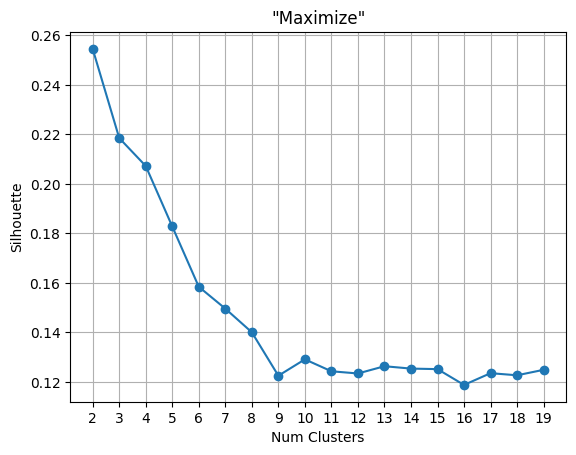

In [42]:
'''Número de agrupaciones utilizando la gráfica K-Elbow y el índice Silhouette'''

np.random.seed(0)
x = x_train
# definimos el numero de clusters
nc = 20

# creamos un diccionario para agregar la informacion
results = {}
for k in range(2, nc):
  k_means = cluster.KMeans(n_clusters=k).fit(x)
  y_pred = k_means.predict(x)
  results[k] = metrics.silhouette_score(x, y_pred)

# agregamos las metricas arrojadas a variables para graficas
clusters_counts = list(results.keys())
index_values = list(results.values())


# graficamos el numero de clusters optimo
plt.plot(clusters_counts, index_values, 'o-')
plt.grid(True)
plt.title('"Maximize"')
plt.xlabel('Num Clusters')
plt.xticks(clusters_counts)
plt.ylabel('Silhouette')
plt.show()

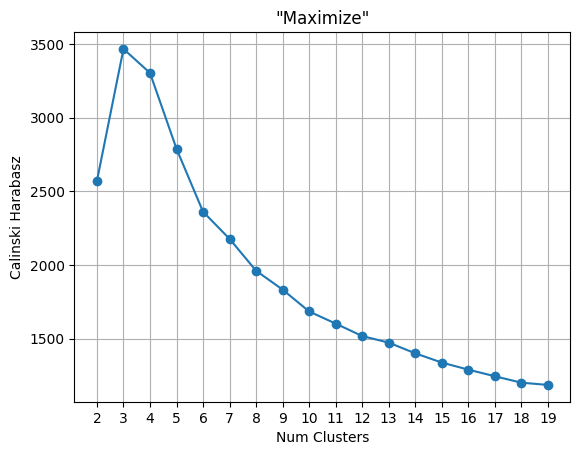

In [43]:
'''Realizamos otra comparacion de nuemro de clusters pero ahora con el indice calinski'''
y_preds = []
results = {}
for k in range(2, nc):
  k_means = cluster.KMeans(n_clusters=k).fit(x)
  y_pred = k_means.predict(x)
  y_preds.append(y_pred)
  results[k] = metrics.calinski_harabasz_score(x, y_pred)

clusters_counts = list(results.keys())
index_values = list(results.values())

# grafica
plt.plot(clusters_counts, index_values, 'o-')
plt.grid(True)
plt.title('"Maximize"')
plt.xlabel('Num Clusters')
plt.xticks(clusters_counts)
plt.ylabel('Calinski Harabasz')
plt.show()

**Se puede observar que una buena referencia para clasificar nuestras tiendas es con 8 clusters, por lo que se realizara una evaluacion con diferentes grupos ara validar como se comporta**

In [44]:
k = 8  # Debido principalmente a las gráficas K-Elbow

k_means = cluster.KMeans(n_clusters=k)
y_pred1 = k_means.fit_predict(x)
s1 = metrics.silhouette_score(x, y_pred1)

single_linkage = cluster.AgglomerativeClustering(linkage="single", n_clusters=k)
y_pred2 = single_linkage.fit_predict(x)
s2 = metrics.silhouette_score(x, y_pred2)

spectral = cluster.SpectralClustering(n_clusters=k, affinity="nearest_neighbors")
y_pred3 = spectral.fit_predict(x)
s3 = metrics.silhouette_score(x, y_pred3)

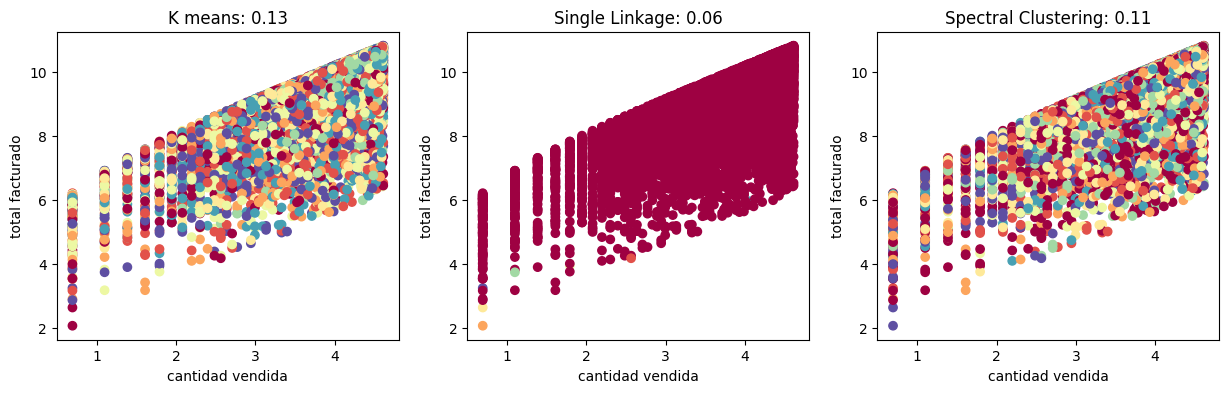

In [45]:
'''Graficamos para comparar los distintos algoritmos'''

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15,4))
ax0.scatter(x_train[:, 1], x_train[:, 7], c=y_pred1, cmap=plt.cm.Spectral)
ax0.set_title('K means: '+"{:.2f}".format(s1))
ax0.set_xlabel("cantidad vendida")
ax0.set_ylabel('total facturado')

ax1.scatter(x_train[:, 1], x_train[:, 7], c=y_pred2, cmap=plt.cm.Spectral)
ax1.set_title('Single Linkage: '+"{:.2f}".format(s2))
ax1.set_xlabel("cantidad vendida")
ax1.set_ylabel('total facturado')

ax2.scatter(x_train[:, 1], x_train[:, 7], c=y_pred3, cmap=plt.cm.Spectral)
ax2.set_title('Spectral Clustering: '+"{:.2f}".format(s3))
ax2.set_xlabel("cantidad vendida")
ax2.set_ylabel('total facturado')
plt.show()

** Segmentación de los Datos **

In [46]:
df_tiendas = df.copy()


# eliminamos algunas variables que no se ocuparan en el analisis
df_tiendas = df_tiendas.drop(columns=["dia_de_la_semana","método_de_pago","fecha_de_venta","id_producto"])

df_tiendas[:3]

,id_tienda,cantidad_vendida,precio_unitario,categoría_de_producto,ubicación_de_tienda,promoción_o_descuento,estacionalidad,nivel_de_inventario,total_facturado,mes,rotacion_inventario
0,Tienda_2,81,498.48,Deportes,Zona Este,1,1,10,40376.88,2,8.10
1,Tienda_1,25,204.46,Juguetes,Zona Norte,0,1,100,5111.50,4,0.25
2,Tienda_6,13,253.30,Alimentos,Zona Este,1,0,100,3292.90,5,0.13


In [61]:
df_tiendas["grupos"] = y_pred1
df_tiendas_ = [df_tiendas[df_tiendas['grupos']==g] for g in range(k)]

# validamos cuantos grupos tenemos:
for g in range(k):
    print('Grupo'+str(g),'has',len(df_tiendas_[g]),'tiendas')

Grupo0 has 926 tiendas
Grupo1 has 1524 tiendas
Grupo2 has 1052 tiendas
Grupo3 has 945 tiendas
Grupo4 has 1442 tiendas
Grupo5 has 844 tiendas
Grupo6 has 1594 tiendas
Grupo7 has 1673 tiendas


In [70]:
'''Describimos nuestros datos'''
grupos_tiendas = pd.DataFrame() #Inicializar un dataframe vacío
# Añadir una columna para poner el nombre de las variables en cada fila
grupos_tiendas['Features'] = df_tiendas.columns[:-1]
# Algoritmo para llenar el dataframe con el promedio de cada variable dentro de cada grupo
for g in range(k):
    row = []
    for col in grupos_tiendas['Features']:
        if df_tiendas_[g][col].dtype != 'object':
            row.append(np.round(df_tiendas_[g][col].mean(),2))
        else:
            row.append(df_tiendas_[g][col].value_counts().keys()[0])
    grupos_tiendas['Grupo'+str(g)] = row

grupos_tiendas

,Features,Grupo0,Grupo1,Grupo2,Grupo3,Grupo4,Grupo5,Grupo6,Grupo7
0,id_tienda,Tienda_8,Tienda_3,Tienda_1,Tienda_7,Tienda_8,Tienda_4,Tienda_9,Tienda_10
1,cantidad_vendida,48.63,50.91,44.57,50.88,51.46,59.6,49.72,51.68
2,precio_unitario,252.16,250.85,239.48,247.41,248.81,279.07,253.47,253.67
3,categoría_de_producto,Ropa,Hogar,Ropa,Alimentos,Electrónica,Electrónica,Deportes,Ropa
4,ubicación_de_tienda,Zona Este,Zona Sur,Zona Sur,Zona Sur,Zona Norte,Zona Sur,Zona Sur,Zona Sur
5,promoción_o_descuento,0.5,0.48,0.55,0.5,0.5,0.52,0.49,0.49
6,estacionalidad,0.51,0.52,0.5,0.48,0.5,0.48,0.51,0.5
7,nivel_de_inventario,138.81,124.25,224.77,147.14,137.18,23.81,133.64,129.38
8,total_facturado,12369.2,12623.63,10637.38,12263.52,12908.07,16212.14,12749.87,13016.1
9,mes,10.14,6.38,10.17,10.09,6.16,10.44,2.49,2.48


In [71]:
grupos_tiendas_ = grupos_tiendas.transpose()
grupos_tiendas_.columns = grupos_tiendas_.loc["Features"]
grupos_tiendas_ = grupos_tiendas_.drop("Features")
grupos_tiendas_ = grupos_tiendas_[["cantidad_vendida","nivel_de_inventario","total_facturado","rotacion_inventario"]]
grupos_tiendas_


Features,cantidad_vendida,nivel_de_inventario,total_facturado,rotacion_inventario
Grupo0,48.63,138.81,12369.2,2.01
Grupo1,50.91,124.25,12623.63,2.39
Grupo2,44.57,224.77,10637.38,0.44
Grupo3,50.88,147.14,12263.52,2.01
Grupo4,51.46,137.18,12908.07,2.25
Grupo5,59.6,23.81,16212.14,5.26
Grupo6,49.72,133.64,12749.87,2.45
Grupo7,51.68,129.38,13016.1,2.53


In [77]:
for i in grupos_tiendas_.columns:
    grupos_tiendas_[i] = grupos_tiendas_[i].astype("float64")

grupos_tiendas_.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, Grupo0 to Grupo7
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cantidad_vendida     8 non-null      float64
 1   nivel_de_inventario  8 non-null      float64
 2   total_facturado      8 non-null      float64
 3   rotacion_inventario  8 non-null      float64
dtypes: float64(4)
memory usage: 620.0+ bytes


In [112]:
import plotly.graph_objects as go
Xt = grupos_tiendas_.apply(lambda x: np.log(x+1)).to_numpy()
fig = go.Figure()
for j in range(len(grupos_tiendas_)):
  fig.add_trace(go.Bar(
      y=Xt[j,:],
      x=grupos_tiendas_.columns,
      name='Group '+str(j)
  ))
fig.update_layout(
    title='Variable por grupo',
    yaxis_title='valores normalizados',
    margin=dict(l=50, r=50, t=50, b=50)
)
fig.show()

<a id = "itc"></a>
## Identificación de tendencias y comportamientos

Text(0, 0.5, 'tienda')

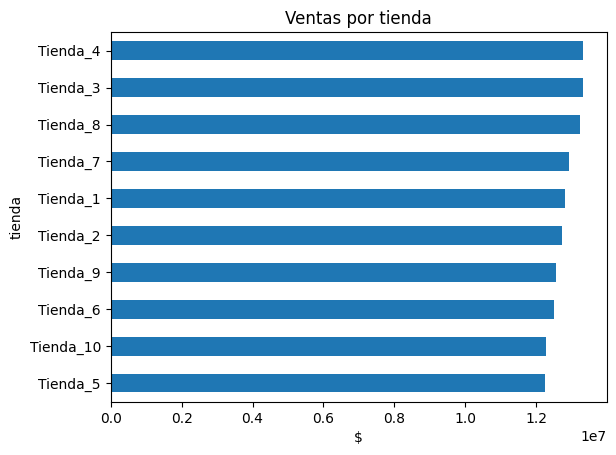

In [117]:
# validamos el comportamiento de ventas por tienda
ventas_tienda = df_ventas.groupby("id_tienda")["total_facturado"].sum()
ventas_tienda = pd.DataFrame(ventas_tienda).sort_values(by="total_facturado",ascending=True)

ventas_tienda.plot(kind="barh",legend=False)
plt.title("Ventas por tienda")
plt.xlabel("$")
plt.ylabel("tienda")

In [118]:
df_ventas[:2]

,id_producto,id_tienda,fecha_de_venta,cantidad_vendida,precio_unitario,categoría_de_producto,ubicación_de_tienda,promoción_o_descuento,estacionalidad,método_de_pago,nivel_de_inventario,total_facturado,dia_de_la_semana,mes
0,Producto_43,Tienda_2,2023-02-13,81,498.48,Deportes,Zona Este,1,1,Efectivo,10,40376.88,0,2
1,Producto_22,Tienda_1,2023-04-19,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100,5111.50,2,4


Text(0, 0.5, 'tienda')

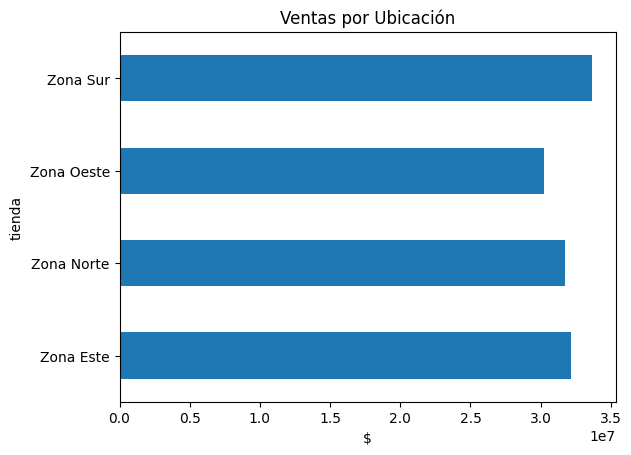

In [120]:
# validamos el comportamiento de ventas por zona
ventas_tienda = df_ventas.groupby("ubicación_de_tienda")["total_facturado"].sum()
ventas_tienda = pd.DataFrame(ventas_tienda).sort_values(by="ubicación_de_tienda",ascending=True)

ventas_tienda.plot(kind="barh",legend=False)
plt.title("Ventas por Ubicación")
plt.xlabel("$")
plt.ylabel("tienda")

In [126]:
# graficamos los datos de ventas por periodo de teimpo para eso crearemos un dataframe que nos permita realizar las operaciones

df_ventas_fecha = df_ventas.groupby("fecha_de_venta").sum()
df_ventas_fecha = df_ventas_fecha.drop(columns=["id_producto","id_tienda","categoría_de_producto","ubicación_de_tienda","promoción_o_descuento","estacionalidad","método_de_pago","dia_de_la_semana",	"mes"])
df_ventas_fecha

,cantidad_vendida,precio_unitario,nivel_de_inventario,total_facturado
fecha_de_venta,,,,
2022-01-01,1171,6663.89,3060,347316.51
2022-01-02,718,4252.12,1205,229416.80
2022-01-03,710,3626.38,1595,198172.70
2022-01-04,638,2686.63,1315,175667.16
2022-01-05,641,3143.36,1525,150057.55
...,...,...,...,...
2023-12-26,1110,5987.08,2475,254892.52
2023-12-27,645,2304.97,1200,161372.80
2023-12-28,941,3632.96,1135,227062.80


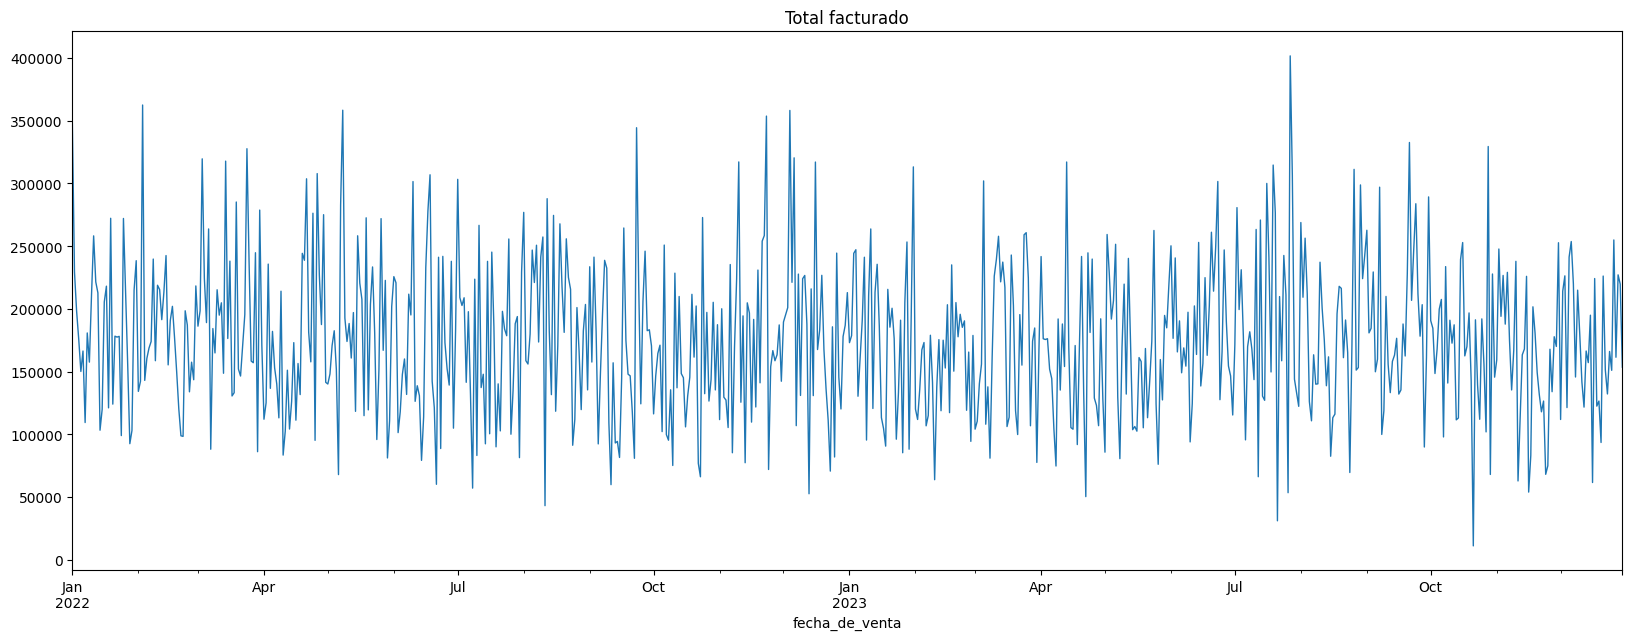

In [133]:
df_ventas_fecha["total_facturado"].plot(style="-",figsize=(20, 7), lw=1,title='Total facturado')
plt.show()

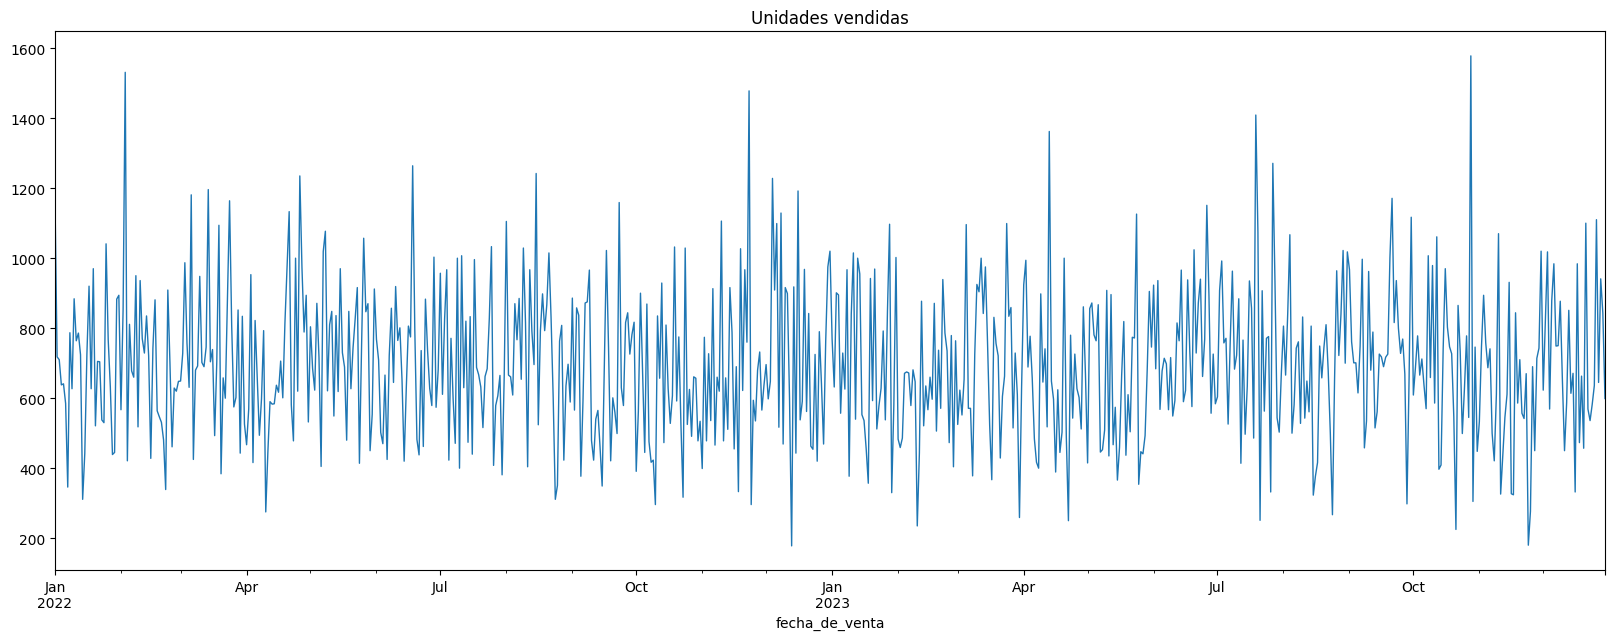

In [135]:
df_ventas_fecha["cantidad_vendida"].plot(style="-",figsize=(20, 7), lw=1,title='Unidades vendidas')
plt.show()

In [145]:
'''Para observar las tendencias de nuestro set de datos utilizaremos el filtro de Hadrick-Prescott a las variables de volumen y ventas $'''

filtrohp_pesos = sm.tsa.filters.hpfilter(df_ventas_fecha["total_facturado"])

datos_tendencia_pesos = filtrohp_pesos[1]
# tendencia de ventas en unidades
filtrohp_unidad = sm.tsa.filters.hpfilter(df_ventas_fecha["cantidad_vendida"])

datos_tendencia_unidad = filtrohp_unidad[1]

df_ventas_fecha["tendencia_$"] = datos_tendencia_pesos
df_ventas_fecha["tendencia_unidades"] = datos_tendencia_unidad

[]

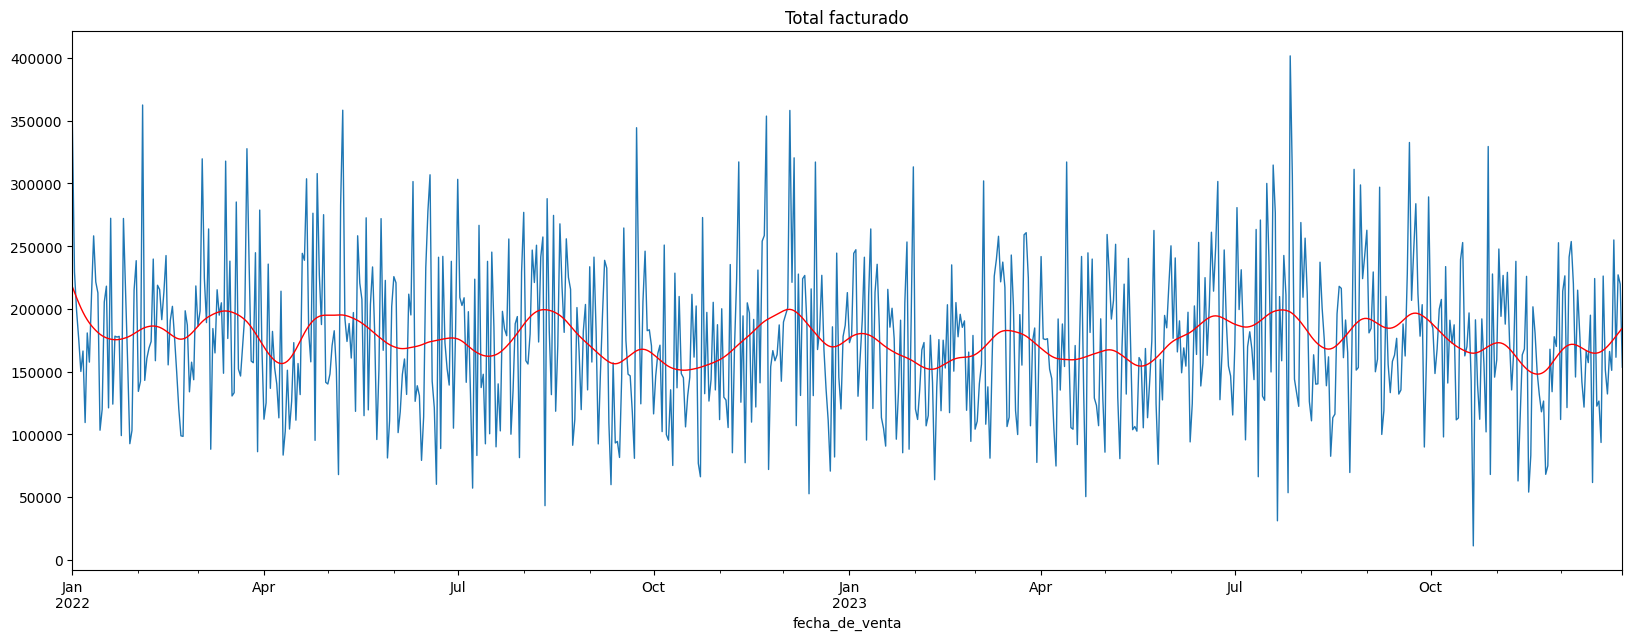

In [146]:
'''Aqui podemos observar la tendencia de las ventas a lo largo de los años 2022 y 2023'''
df_ventas_fecha["total_facturado"].plot(style="-",figsize=(20, 7), lw=1,title='Total facturado')
df_ventas_fecha["tendencia_$"].plot(style="-",figsize=(20, 7), lw=1,title='Total facturado',color = "red")
plt.plot()

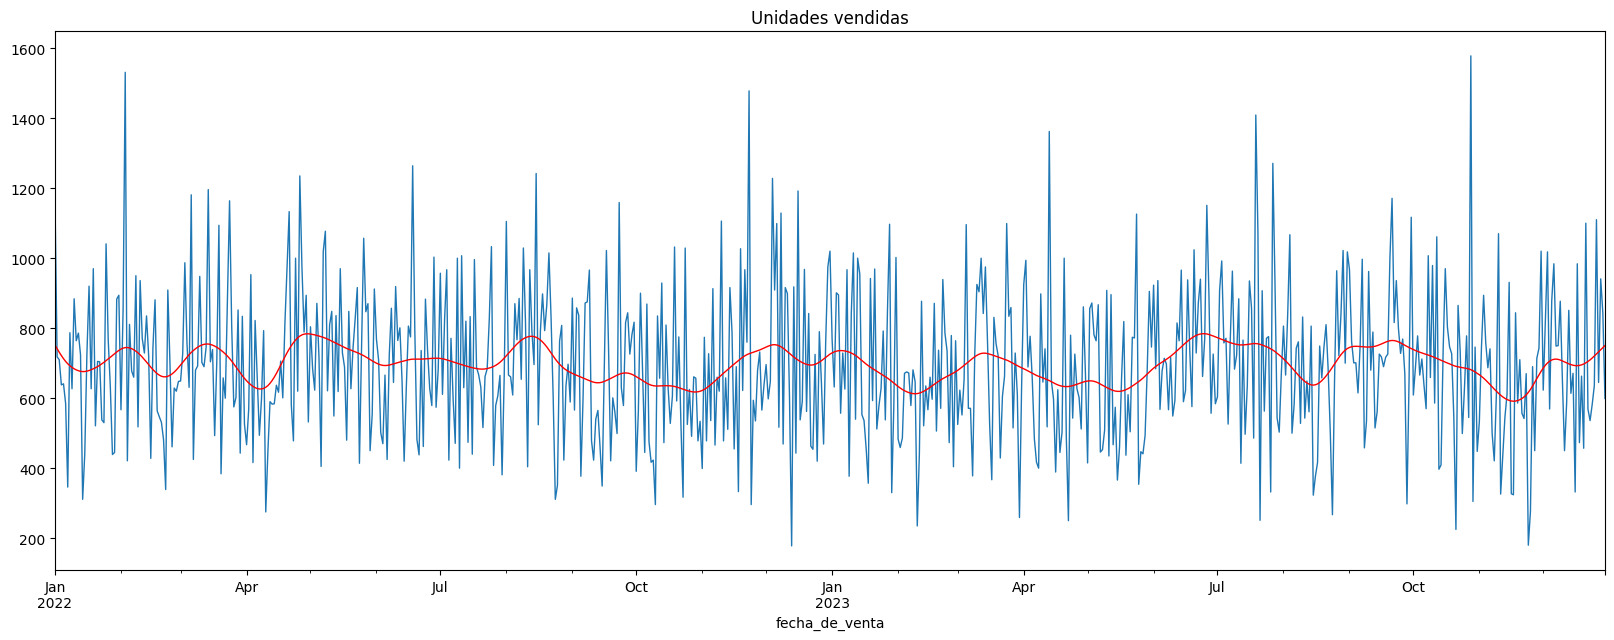

In [147]:
df_ventas_fecha["cantidad_vendida"].plot(style="-",figsize=(20, 7), lw=1,title='Unidades vendidas')
df_ventas_fecha["tendencia_unidades"].plot(style="-",figsize=(20, 7), lw=1,title='Unidades vendidas',color = "red")
plt.show()

<a id = "epvf"></a>
## Estrategia para predecir ventas futuras

In [ ]:
'''
Derivado al tipo de informacion con la que se cuenta,podemos argumentar el uso del algoritmo de XGBoost

1. Los datos tienen una estructura tabular y contienen principalmente variables numéricas 
(cantidad_vendida, precio_unitario, nivel_de_inventario, total_facturado) 
con distribuciones variadas y escalas diferentes.

ESto nos da la ventaja, ya que algoritmo está optimizado para manejar datos tabulares y trabajar bien 
con diferentes escalas de valores, sin requerir una normalización explícita (aunque se utilizara para ver el desempeño del modelo).
'''

In [153]:
# comenzamos a crear atributos para hacer nuestro set mas robusto
df_ventas_fecha_copy = df_ventas_fecha.copy()
df_ventas_fecha_copy['dia'] = df_ventas_fecha_copy.index.day
df_ventas_fecha_copy['dia_semana'] = df_ventas_fecha_copy.index.dayofweek
df_ventas_fecha_copy['mes'] = df_ventas_fecha_copy.index.month
df_ventas_fecha_copy['cuatrimestre'] = df_ventas_fecha_copy.index.quarter
df_ventas_fecha_copy['año'] = df_ventas_fecha_copy.index.year
df_ventas_fecha_copy['dia_del_año'] = df_ventas_fecha_copy.index.dayofyear

df_ventas_fecha_copy

,cantidad_vendida,precio_unitario,nivel_de_inventario,total_facturado,tendencia_$,tendencia_unidades,dia,dia_semana,mes,cuatrimestre,año,dia_del_año
fecha_de_venta,,,,,,,,,,,,
2022-01-01,1171,6663.89,3060,347316.51,217567.467509,751.716814,1,5,1,1,2022,1
2022-01-02,718,4252.12,1205,229416.80,213170.165578,741.395625,2,6,1,1,2022,2
2022-01-03,710,3626.38,1595,198172.70,208853.956798,731.336488,3,0,1,1,2022,3
2022-01-04,638,2686.63,1315,175667.16,204710.088467,721.786832,4,1,1,1,2022,4
2022-01-05,641,3143.36,1525,150057.55,200823.132099,712.980753,5,2,1,1,2022,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,1110,5987.08,2475,254892.52,176004.342813,726.505823,26,1,12,4,2023,360
2023-12-27,645,2304.97,1200,161372.80,178172.827771,732.559884,27,2,12,4,2023,361
2023-12-28,941,3632.96,1135,227062.80,180358.475015,738.579983,28,3,12,4,2023,362


In [154]:
df_ventas_fecha_copy.drop(columns=["tendencia_$",	"tendencia_unidades"], inplace = True)
df_ventas_fecha_copy[:3]

,cantidad_vendida,precio_unitario,nivel_de_inventario,total_facturado,dia,dia_semana,mes,cuatrimestre,año,dia_del_año
fecha_de_venta,,,,,,,,,,
2022-01-01,1171,6663.89,3060,347316.51,1,5,1,1,2022,1
2022-01-02,718,4252.12,1205,229416.80,2,6,1,1,2022,2
2022-01-03,710,3626.38,1595,198172.70,3,0,1,1,2022,3


In [155]:
df_ventas_fecha_copy.columns

Index(['cantidad_vendida', 'precio_unitario', 'nivel_de_inventario',
       'total_facturado', 'dia', 'dia_semana', 'mes', 'cuatrimestre', 'año',
       'dia_del_año'],
      dtype='object')

In [157]:
'''Procedemos a preparar los conjuntos de entrenamiento y validacion'''

# dividir en 4 
ts_cv = TimeSeriesSplit(n_splits=4)

fold = 0
preds = []
scores = []

for train_idx, val_idx in ts_cv.split(df_ventas_fecha_copy):
    train = df_ventas_fecha_copy.iloc[train_idx]
    test = df_ventas_fecha_copy.iloc[val_idx]

    #seleccionamos las variables

    caracteristicas = ['cantidad_vendida', 'precio_unitario', 'nivel_de_inventario',
       'dia', 'dia_semana', 'mes', 'cuatrimestre', 'año',
       'dia_del_año']
    var_objetivo = ['total_facturado']
    
    #dividir atributos y variable de salida 
    X_train = train[caracteristicas]
    y_train = train[var_objetivo]

    X_test = test[caracteristicas]
    y_test = test[var_objetivo]

    #crear instancia del regresor 
    xgb_reg = xgb.XGBRegressor(booster='gbtree',
                               seed=42,        
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:squarederror',
                               reg_lambda=0.001, 
                               max_depth=5,
                               eta=0.01)
    #entrenamos el modelo 
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)
    
    #predicciones y evaluacion
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:60388.39482	validation_1-rmse:62435.58665
[100]	validation_0-rmse:24414.68489	validation_1-rmse:35570.68244
[200]	validation_0-rmse:11320.81704	validation_1-rmse:29624.34248
[300]	validation_0-rmse:6306.07907	validation_1-rmse:28768.01897
[400]	validation_0-rmse:4425.94326	validation_1-rmse:28360.44634
[500]	validation_0-rmse:3467.74117	validation_1-rmse:28220.94910
[553]	validation_0-rmse:2935.23839	validation_1-rmse:28260.21290
[0]	validation_0-rmse:61059.48867	validation_1-rmse:61130.36701
[100]	validation_0-rmse:26579.32271	validation_1-rmse:31553.49313
[200]	validation_0-rmse:14458.48077	validation_1-rmse:27287.27050
[279]	validation_0-rmse:10404.65468	validation_1-rmse:27204.41118
[0]	validation_0-rmse:61066.77492	validation_1-rmse:62513.11340
[100]	validation_0-rmse:27904.64104	validation_1-rmse:33991.84336
[200]	validation_0-rmse:16833.53869	validation_1-rmse:27114.00238
[300]	validation_0-rmse:12781.88621	validation_1-rmse:25688.85963
[400]	validation_0-r

In [158]:
# validamos el score obtenido
print('Fold scores:', scores)
print('Avg. Score:', np.mean(scores))

Fold scores: [np.float64(28214.377507481877), np.float64(27116.893169275387), np.float64(25383.517683020185), np.float64(25525.751153667647)]
Avg. Score: 26560.134878361274


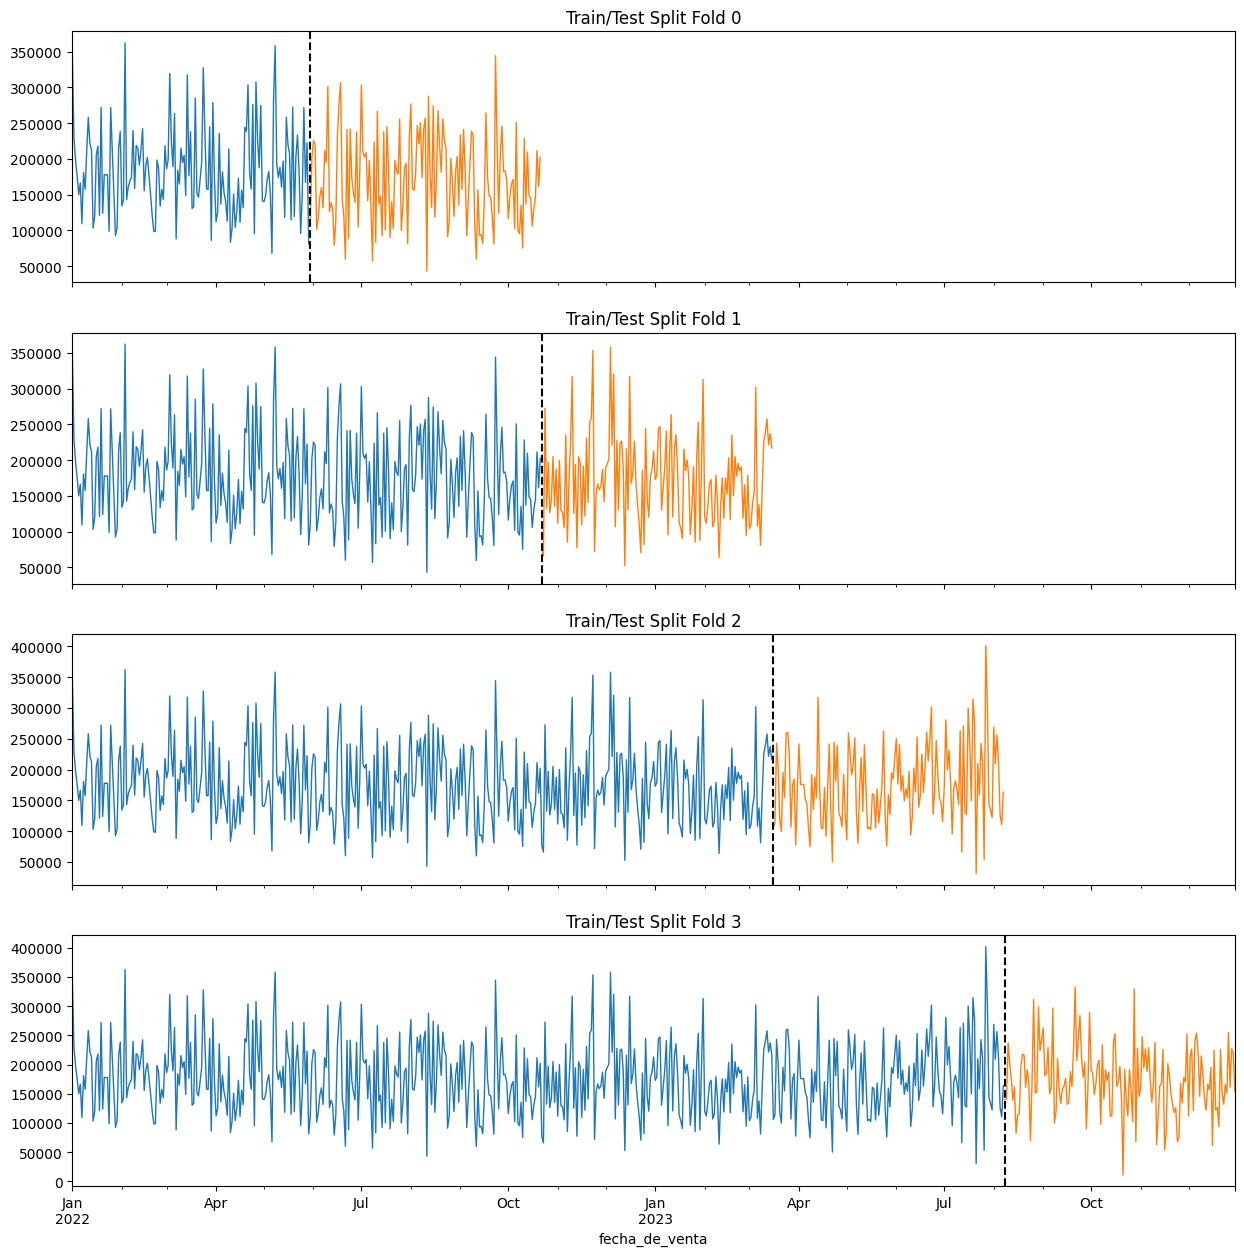

In [160]:
'''Graficamos '''

fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in ts_cv.split(df_ventas_fecha_copy):
    train = df_ventas_fecha_copy.iloc[train_idx]
    test = df_ventas_fecha_copy.iloc[val_idx]
    train['total_facturado'].plot(ax=axs[fold], lw=1,
                      label='Training Set',
                      title=f'Train/Test Split Fold {fold}')
    test['total_facturado'].plot(ax=axs[fold], lw=1,
                     label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

<a id = "gpee"></a>
## Generación de predicciones y evaluación del error 

In [161]:
'''Una ves generado el modelo podemos realizar las predicciones usando toda la informacion y de esta manera aprovechar y robustecer la información'''

df_ventas_fecha_copy = df_ventas_fecha.copy()
df_ventas_fecha_copy['dia'] = df_ventas_fecha_copy.index.day
df_ventas_fecha_copy['dia_semana'] = df_ventas_fecha_copy.index.dayofweek
df_ventas_fecha_copy['mes'] = df_ventas_fecha_copy.index.month
df_ventas_fecha_copy['cuatrimestre'] = df_ventas_fecha_copy.index.quarter
df_ventas_fecha_copy['año'] = df_ventas_fecha_copy.index.year
df_ventas_fecha_copy['dia_del_año'] = df_ventas_fecha_copy.index.dayofyear

df_ventas_fecha_copy.drop(columns=["tendencia_$",	"tendencia_unidades"], inplace = True)
df_ventas_fecha_copy[:3]

caracteristicas = ['cantidad_vendida', 'precio_unitario', 'nivel_de_inventario',
       'dia', 'dia_semana', 'mes', 'cuatrimestre', 'año',
       'dia_del_año']
var_objetivo = ['total_facturado']

X_full = df_ventas_fecha_copy[caracteristicas]
y_full = df_ventas_fecha_copy[var_objetivo]

In [163]:
# instanciamos el regresor
xgb_r = xgb.XGBRegressor(booster='gbtree',
                            seed=42,        
                            n_estimators=1000,
                            early_stopping_rounds=50,
                            objective='reg:squarederror',
                            reg_lambda=0.001,
                            max_depth=5,
                            eta=0.01)
# entrenamos el modelo
xgb_r.fit(X_full, y_full,
        eval_set=[(X_full, y_full)],
        verbose=100)

[0]	validation_0-rmse:60551.56309
[100]	validation_0-rmse:28767.69801
[200]	validation_0-rmse:18959.03442
[300]	validation_0-rmse:15596.15550
[400]	validation_0-rmse:13682.05275
[500]	validation_0-rmse:12551.82048
[600]	validation_0-rmse:11676.24548
[700]	validation_0-rmse:10861.10100
[800]	validation_0-rmse:10151.35508
[900]	validation_0-rmse:9429.62420
[999]	validation_0-rmse:8756.84239


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [168]:
print(max(df_ventas["fecha_de_venta"]))
print(min(df_ventas["fecha_de_venta"]))

2023-12-30 00:00:00
2022-01-01 00:00:00


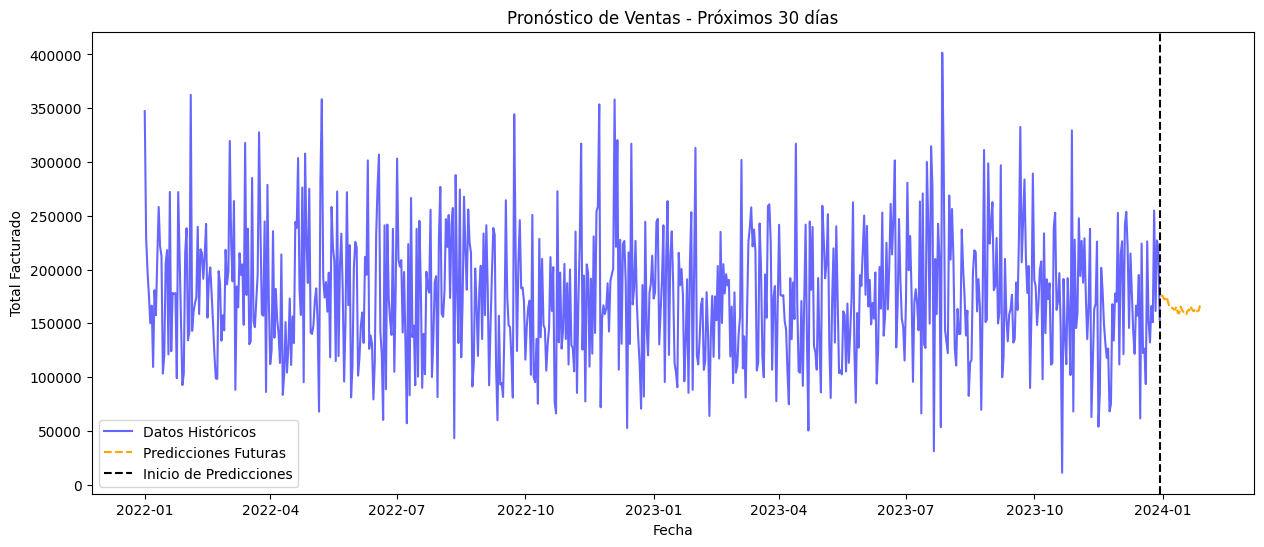

In [195]:
# Crear el DataFrame de predicciones con fechas 30 días
fecha_max = pd.to_datetime("2023-12-30")  
fechas_futuras = pd.date_range(start=fecha_max + pd.Timedelta(days=1), periods=30, freq='D')
df_futuras = pd.DataFrame(index=fechas_futuras)
df_futuras.index.name = 'fecha_de_venta'

# Crear características 
df_futuras['dia'] = df_futuras.index.day
df_futuras['dia_semana'] = df_futuras.index.dayofweek
df_futuras['mes'] = df_futuras.index.month
df_futuras['cuatrimestre'] = df_futuras.index.quarter
df_futuras['año'] = df_futuras.index.year
df_futuras['dia_del_año'] = df_futuras.index.dayofyear

# Agregar valores ficticios para otras características necesarias
df_futuras['cantidad_vendida'] = df_ventas_fecha_copy['cantidad_vendida'].mean()
df_futuras['precio_unitario'] = df_ventas_fecha_copy['precio_unitario'].mean()
df_futuras['nivel_de_inventario'] = df_ventas_fecha_copy['nivel_de_inventario'].mean()

# Seleccionar las características necesarias para el modelo
X_futuras = df_futuras[caracteristicas]

# Predicciones con el modelo entrenado
df_futuras['total_facturado_pred'] = xgb_r.predict(X_futuras)

# Concatenamos datos originales con las predicciones futuras
df_completo = pd.concat([df_ventas_fecha_copy, df_futuras[['total_facturado_pred']]], axis=0)

#graficamos
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df_ventas_fecha_copy.index, df_ventas_fecha_copy['total_facturado'], label='Datos Históricos', color='blue',alpha = 0.6)
plt.plot(df_futuras.index, df_futuras['total_facturado_pred'], label='Predicciones Futuras', color='orange', linestyle='--')
plt.axvline(x=fecha_max, color='black', linestyle='--', label='Inicio de Predicciones')
plt.legend()
plt.title('Pronóstico de Ventas - Próximos 30 días')
plt.xlabel('Fecha')
plt.ylabel('Total Facturado')
plt.show()

**Validacion del conjunto**

In [197]:
# Ordenamos los datos ya que es orden temporal
df_ventas_fecha_copy = df_ventas_fecha_copy.sort_index()

# Definir el tamaño del conjunto de validación
dias_validacion = 30

# Índices de separación
train_data = df_ventas_fecha_copy.iloc[:-dias_validacion] 
val_data = df_ventas_fecha_copy.iloc[-dias_validacion:] 

# Características y variable objetivo
caracteristicas = ['cantidad_vendida', 'precio_unitario', 'nivel_de_inventario',
                   'dia', 'dia_semana', 'mes', 'cuatrimestre', 'año', 'dia_del_año']
var_objetivo = ['total_facturado']

# separamos la variable objetivo de las carcateristicas
X_train = train_data[caracteristicas]
y_train = train_data[var_objetivo]

X_val = val_data[caracteristicas]
y_val = val_data[var_objetivo]

# tamaño de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}, {y_val.shape}")


Tamaño del conjunto de entrenamiento: (699, 9), (699, 1)
Tamaño del conjunto de validación: (30, 9), (30, 1)


In [198]:
# entrenamos nuevamente:
xgb_r = xgb.XGBRegressor(
    booster='gbtree',
    seed=42,
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    reg_lambda=0.001,
    max_depth=5,
    eta=0.01
)

# Entrenamos el modelo con el conjunto de entrenamiento
xgb_r.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

[0]	validation_0-rmse:60973.16441	validation_1-rmse:49636.06530
[100]	validation_0-rmse:28808.46341	validation_1-rmse:24415.90333
[174]	validation_0-rmse:20509.56728	validation_1-rmse:24113.61869


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [200]:
# evaluacion de resultados
y_pred = xgb_reg.predict(X_val)

#calculo de metricas de error
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")


MAE (Error Absoluto Medio): 16489.50
RMSE (Raíz del Error Cuadrático Medio): 21997.39


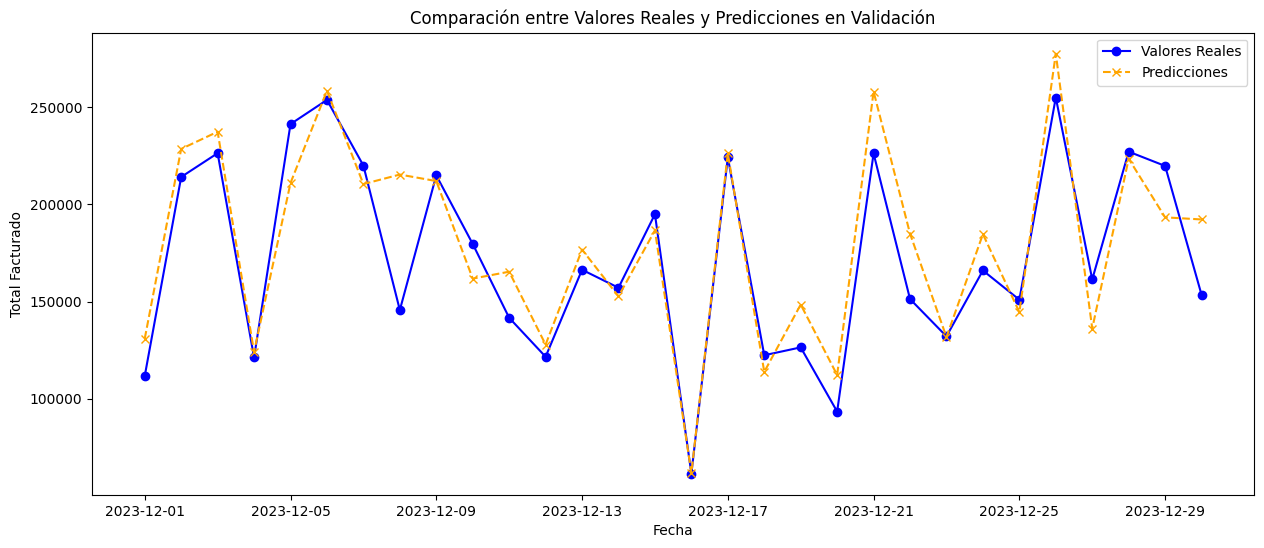

In [201]:
# visualizamos los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(val_data.index, y_val, label='Valores Reales', color='blue', marker='o')
plt.plot(val_data.index, y_pred, label='Predicciones', color='orange', linestyle='--', marker='x')
plt.title('Comparación entre Valores Reales y Predicciones en Validación')
plt.xlabel('Fecha')
plt.ylabel('Total Facturado')
plt.legend()
plt.show()
